<a href="https://colab.research.google.com/github/RobertGrados/RobertGrados/blob/main/Another_copy_of_SEAS6414_HW8_RGrados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SEAS 6414 HW8
# This homework focuses on analyzing and forecasting merchant transaction data using
# various time series techniques. The primary objective is to apply different forecasting
# models and evaluate their performance in predicting future transaction volumes.


In [ ]:
cd C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8

C:\Users\1126692\Desktop\Desktop Files\Papers\GWU PhD\Python Lectures\Lecture8


In [ ]:
pwd

'C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8'

In [2]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Read the data from CSV
# Sets the "time" column as the index. With parse_dates=True argument ensuring dates are parsed correctly
#df = pd.read_csv("homework8.csv", index_col="time", parse_dates=True)
df = pd.read_csv("Homework8.csv", index_col=["time"], parse_dates=["time"])
df.head(10)

# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")]

# Resample data to daily transaction sums
daily_transactions = df.resample("D")["amount_usd_in_cents"].sum()/100  # Total transactions in US Dollars per Day

# Print the resulting DataFrame (optional)
print(daily_transactions.head())

# Save the resampled data (optional)
daily_transactions.to_csv("daily_transactions.csv")

time
2033-01-01    3375.05
2033-01-02    2632.34
2033-01-03    2681.87
2033-01-04    2176.44
2033-01-05    3889.32
Freq: D, Name: amount_usd_in_cents, dtype: float64


In [4]:
df.head()

Unnamed: 0    merchant  amount_usd_in_cents
time                                                            
2034-06-17 23:34:14           1  faa029c6b0               6349.0
2034-12-27 00:40:38           2  ed7a7d91aa               3854.0
2034-04-30 01:29:42           3  5608f200cf                789.0
2034-09-16 01:06:23           4  15b1a0d61e               4452.0
2034-07-22 16:21:42           5  4770051790              20203.0

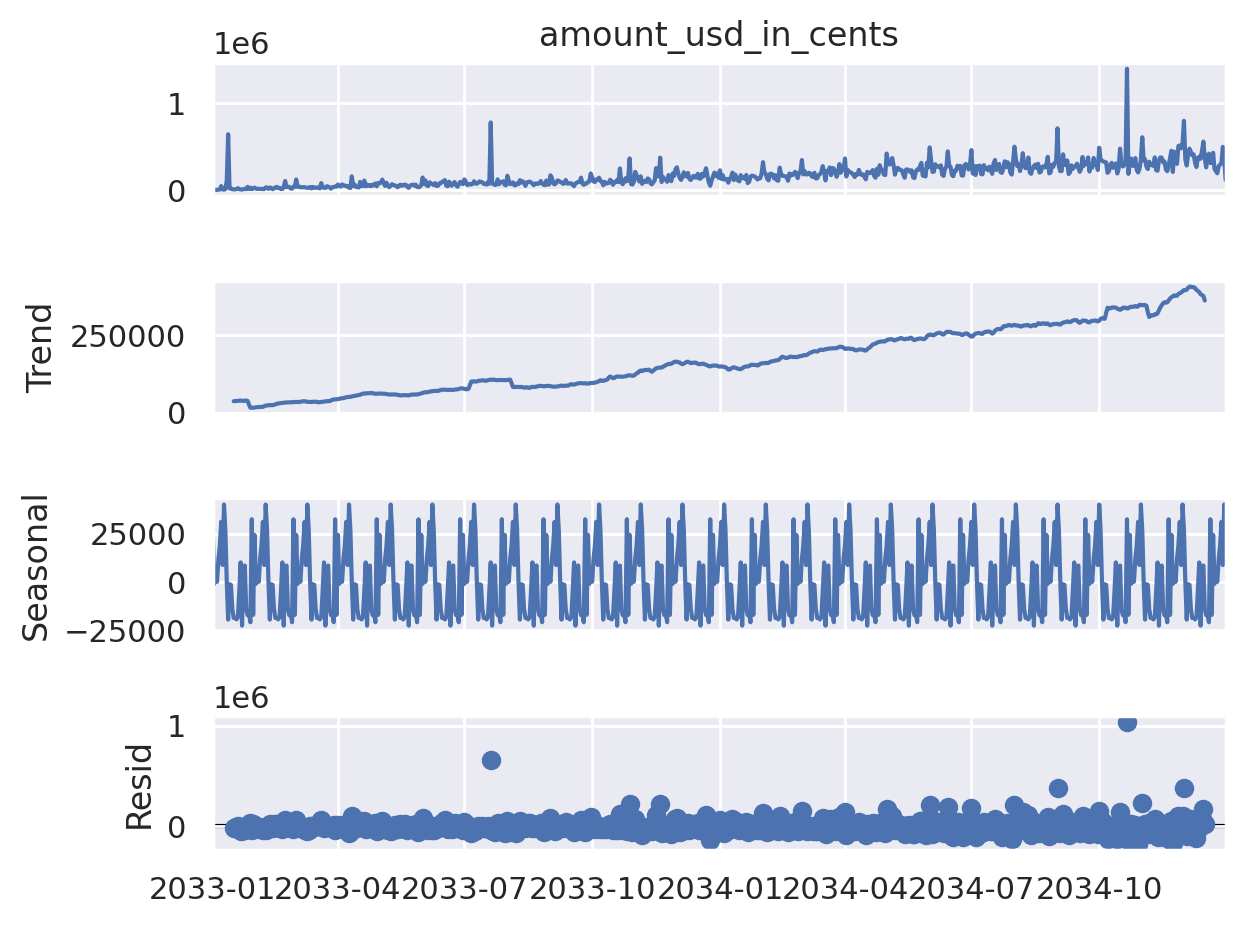

In [5]:
# Plot Trend and Data Seasonality
# Import extra libraries
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Holt Winters
# Single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# double and triple exponentiial smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data = pd.read_csv('daily_transactions.csv', index_col = 'time', parse_dates=True)
decompose_result = seasonal_decompose(data['amount_usd_in_cents'],period=30) # Note: Data is in US Dollars not cents
decompose_result.plot(); # Plot Seasonality and Trend of Raw Data Only

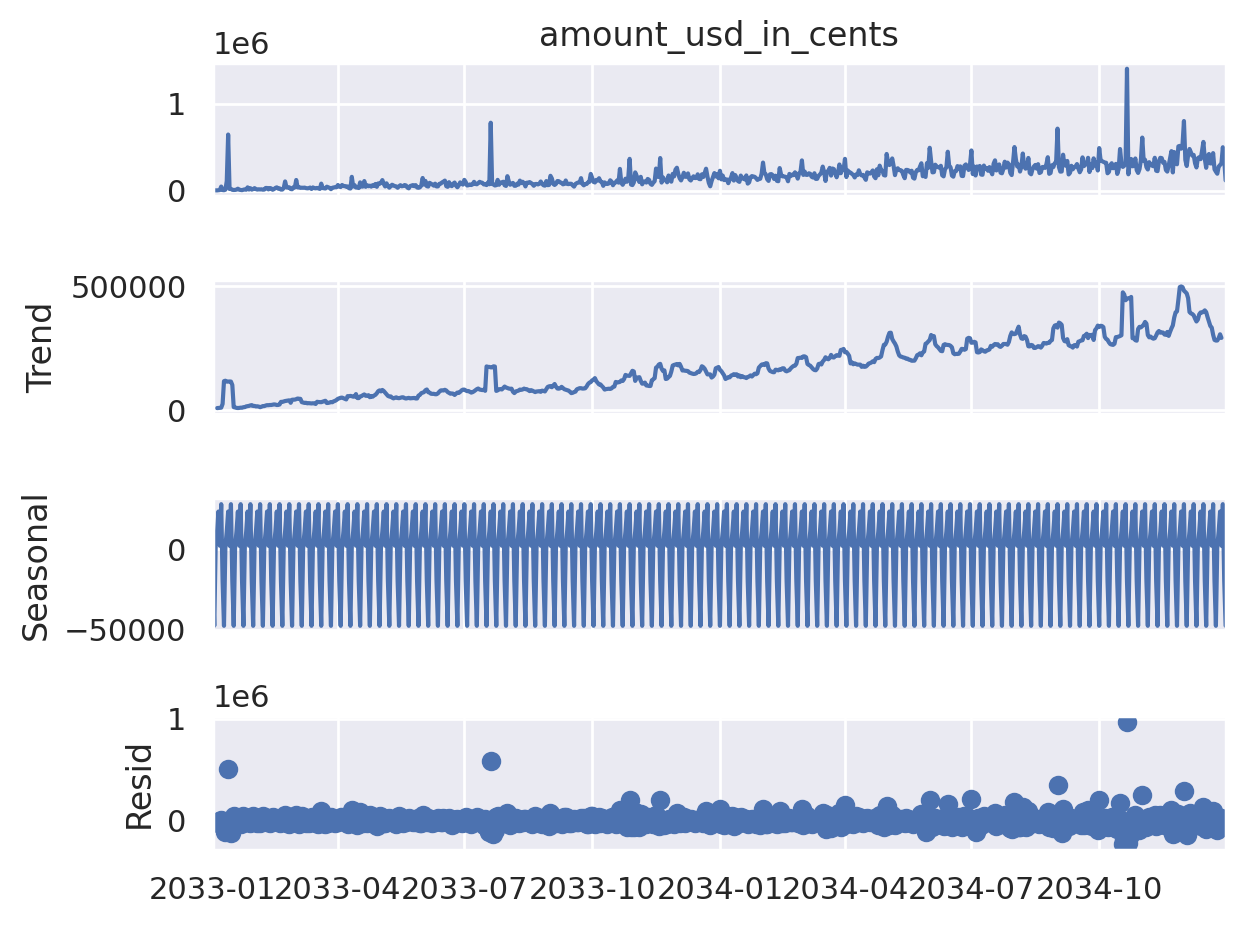

In [6]:
decompose_result = seasonal_decompose(data['amount_usd_in_cents'],period=7) # Note: Data is in US Dollars not cents
decompose_result.plot(); # Plot Seasonality and Trend of Raw Data Only

In [7]:
# Top plot is in US-Dollars not in cents
# Notice upward trend as well as the 30 days Seasonality, and 7 day Seasonality (second set of plots below)

In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

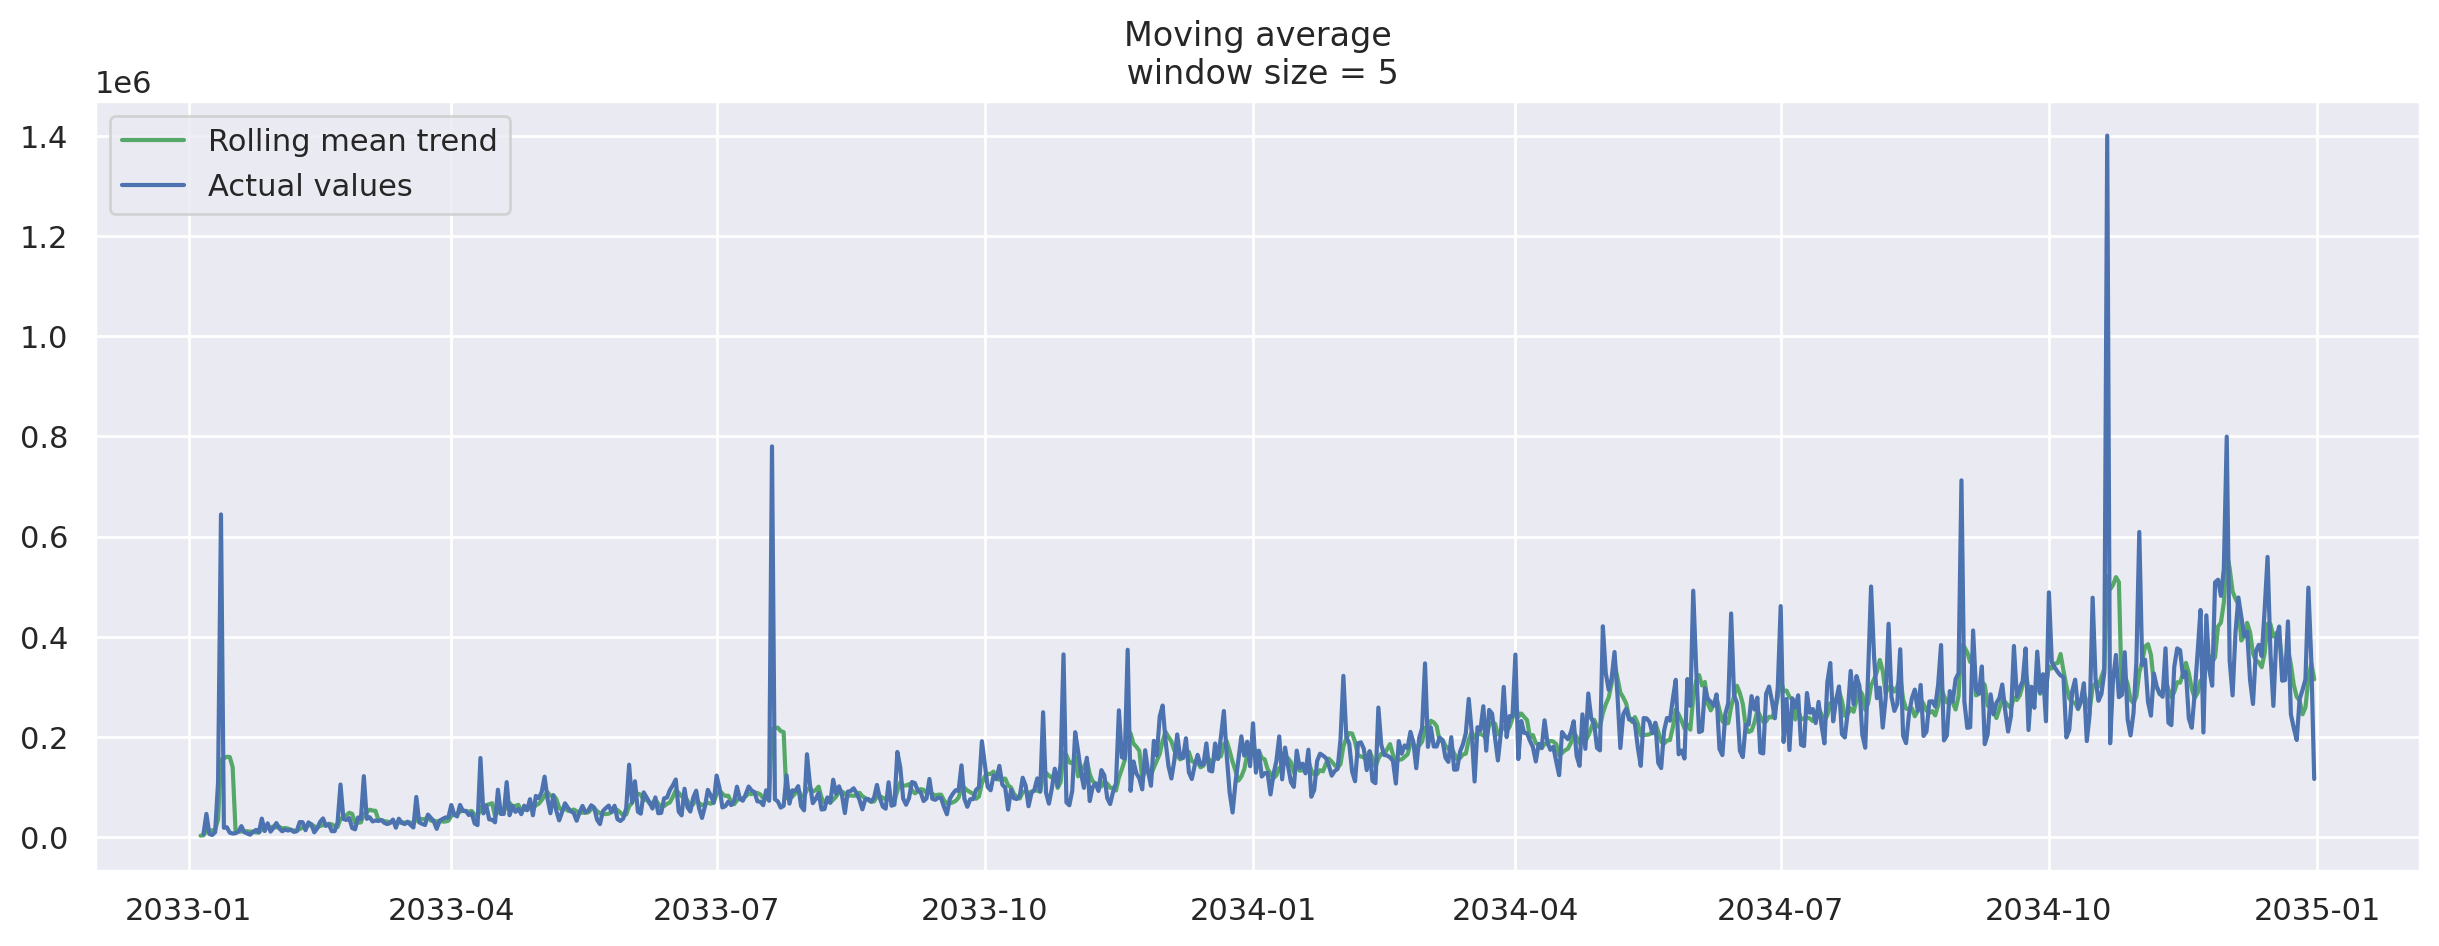

In [9]:
    Dollar_series = df.resample("D")["amount_usd_in_cents"].sum()/100
    plotMovingAverage(Dollar_series, 5)

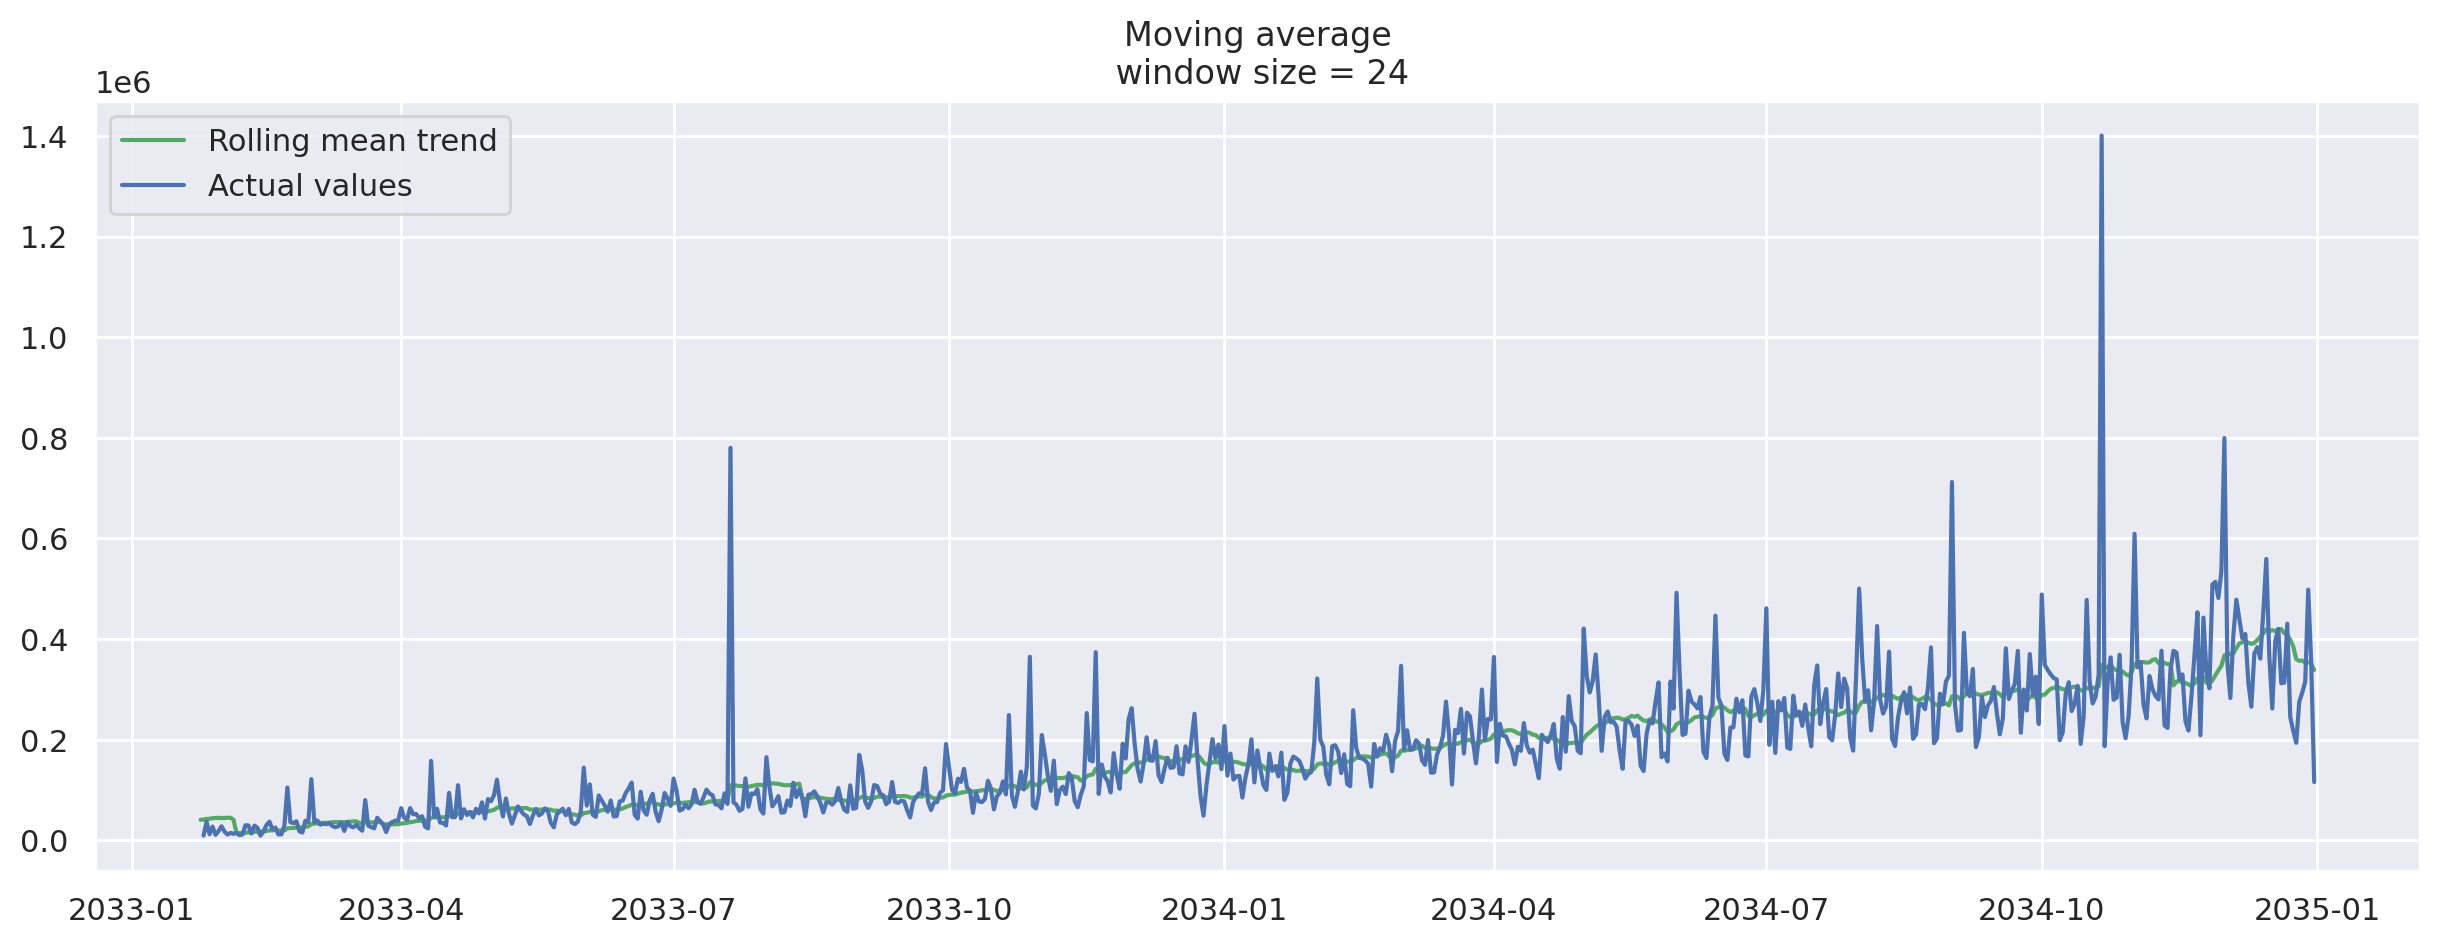

In [10]:

    plotMovingAverage(Dollar_series, 24)

In [11]:
# Importing everything from above

from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [13]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method

    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [14]:
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [17]:
%%time
data = Dollar_series[:-20]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
print("Model Triple Expnentail Smoothing Paramenters (above):\n")
model.triple_exponential_smoothing()


0.00706923655266839 0.02997278443420226 0.0943605026739271
Model Triple Expnentail Smoothing Paramenters (above):

CPU times: user 5.7 s, sys: 24.1 ms, total: 5.72 s
Wall time: 8.31 s


In [18]:
model.initial_seasonal_components()

{0: -13970.755890804596,
 1: -3671.2517528735607,
 2: -13696.260373563216,
 3: -17728.142442528733,
 4: -16284.456235632184,
 5: 2781.159971264369,
 6: 1417.4568678160942,
 7: -3468.2203735632183,
 8: 25252.25721264369,
 9: -10381.615201149425,
 10: 52254.33341954024,
 11: 10405.7416954023,
 12: 20152.758936781607,
 13: -2206.4458908045985,
 14: -765.2565804597679,
 15: -11930.479339080457,
 16: 2159.474798850578,
 17: -10099.516925287351,
 18: 5393.561695402298,
 19: -10733.668304597702,
 20: 605.2661781609208,
 21: -972.9958908045966,
 22: -6899.611752873564,
 23: 2386.666178160921}

In [19]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[: len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[: len(series)]] = series.values[
            series.values < model.LowerBond[: len(series)]
        ]
        anomalies[series.values > model.UpperBond[: len(series)]] = series.values[
            series.values > model.UpperBond[: len(series)]
        ]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(
            x=range(0, len(model.result)),
            y1=model.UpperBond,
            y2=model.LowerBond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        len(series),
        ymin=min(model.LowerBond),
        ymax=max(model.UpperBond),
        linestyles="dashed",
    )
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

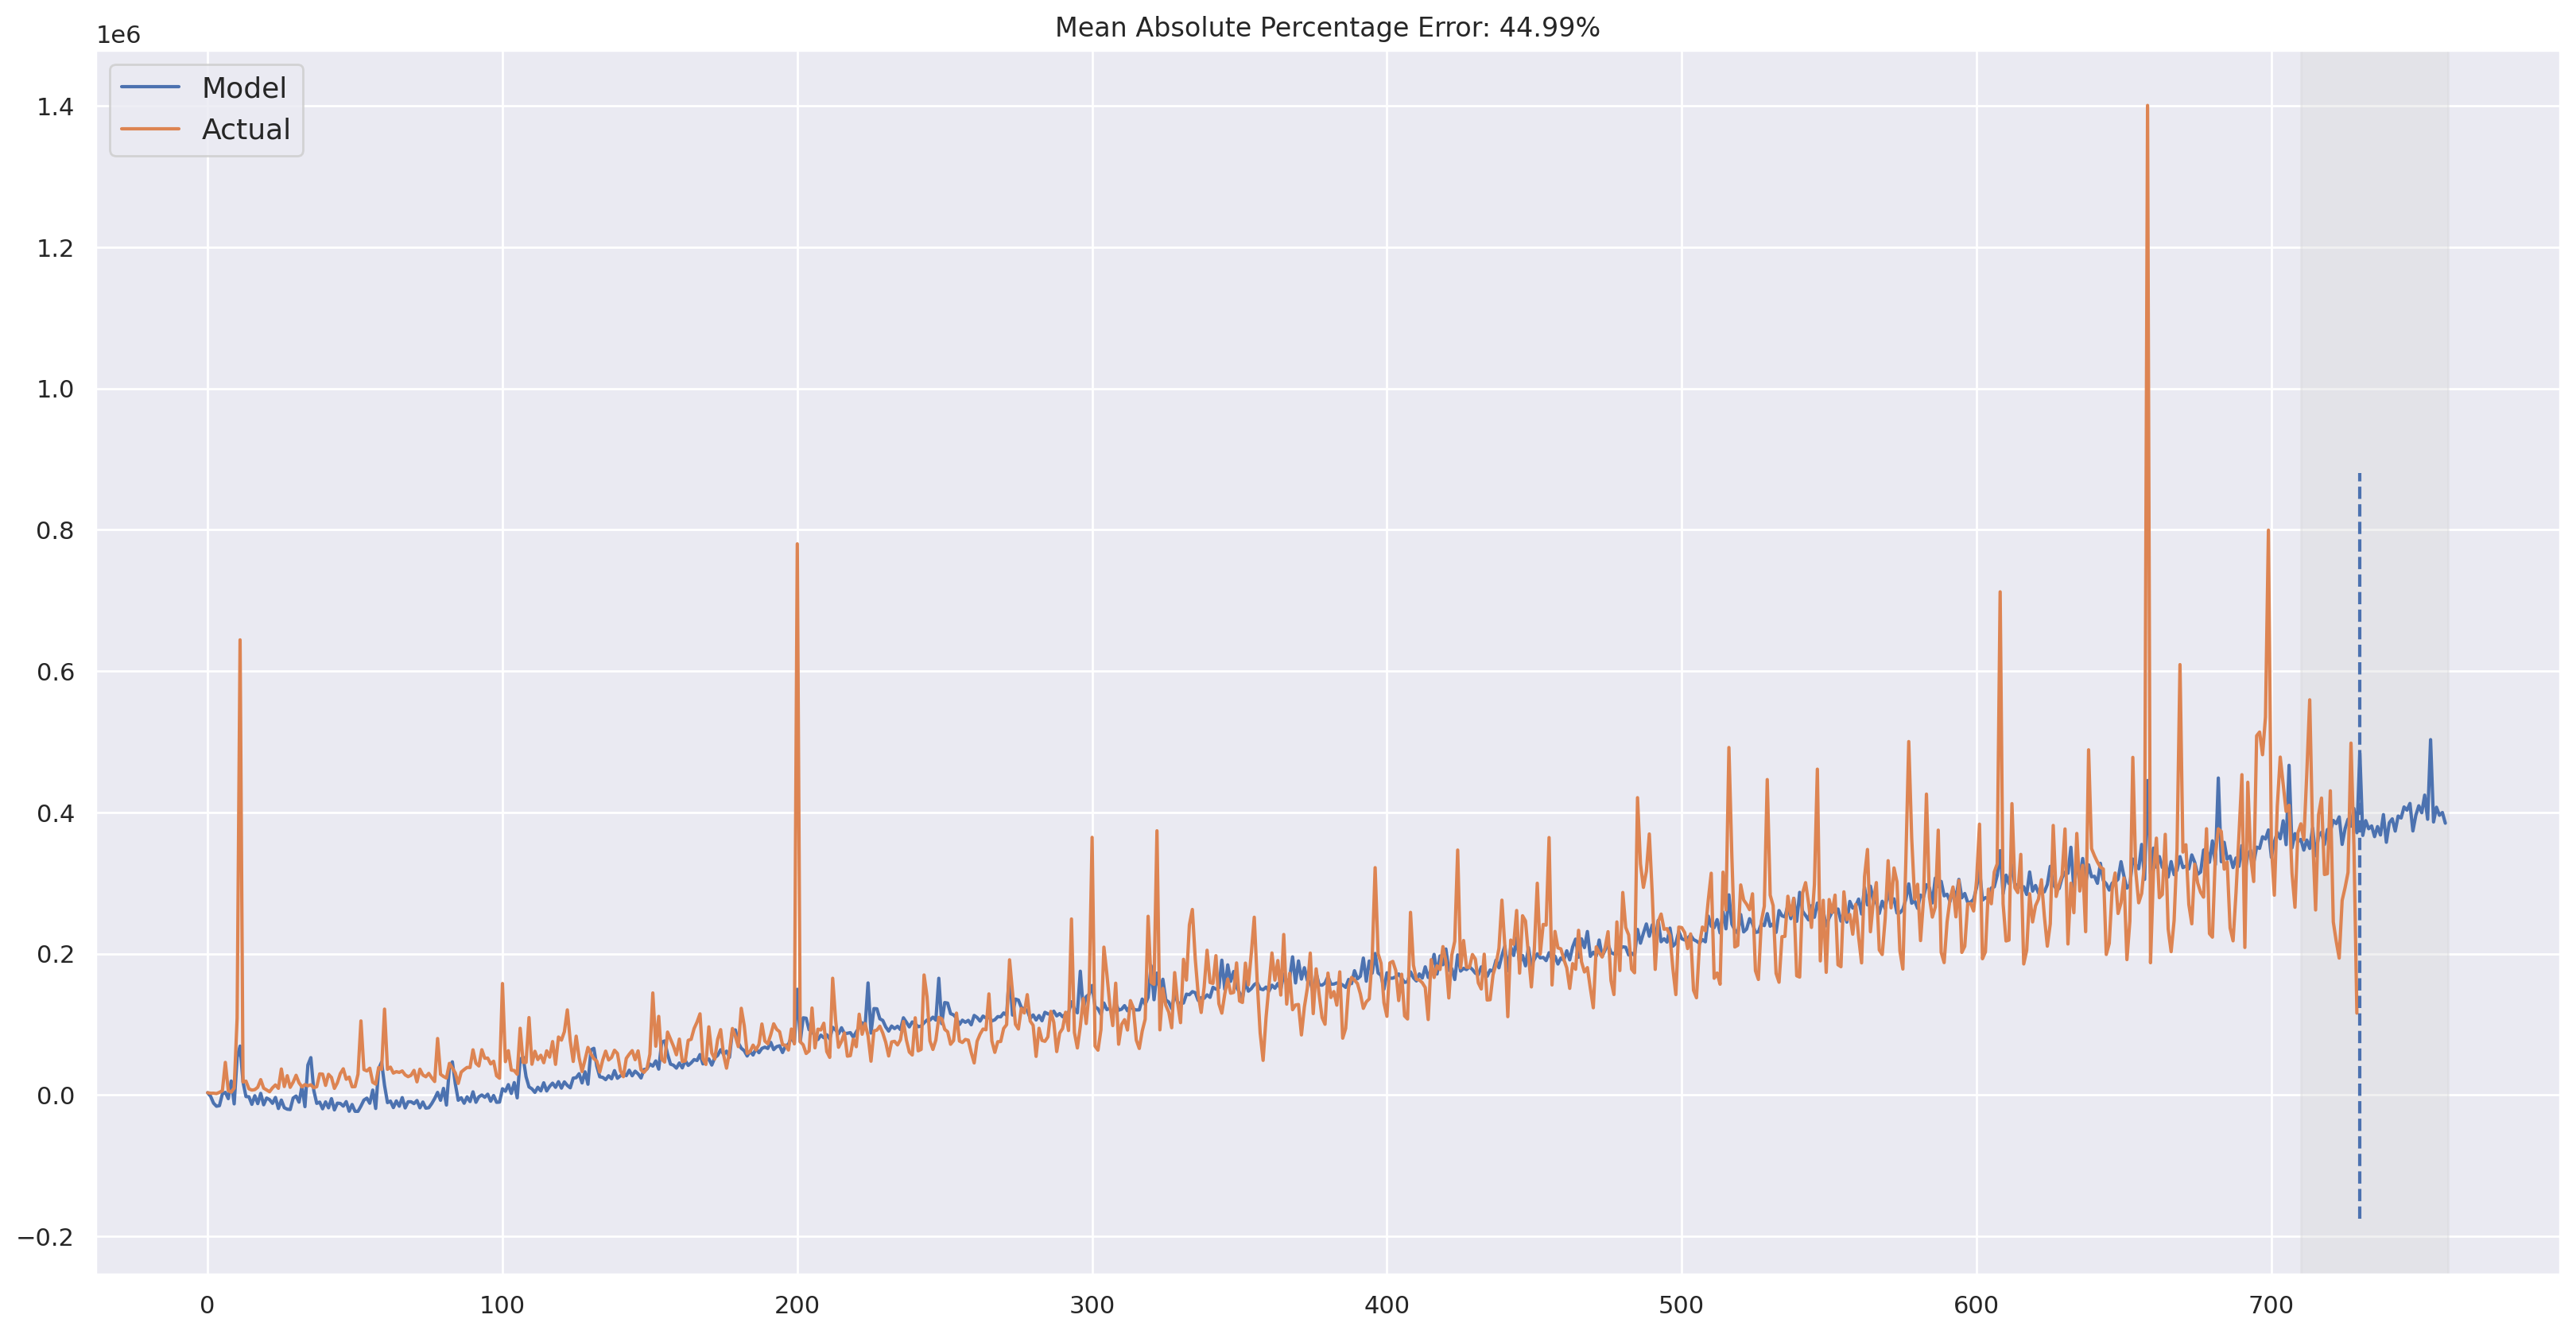

In [20]:
plotHoltWinters(Dollar_series)

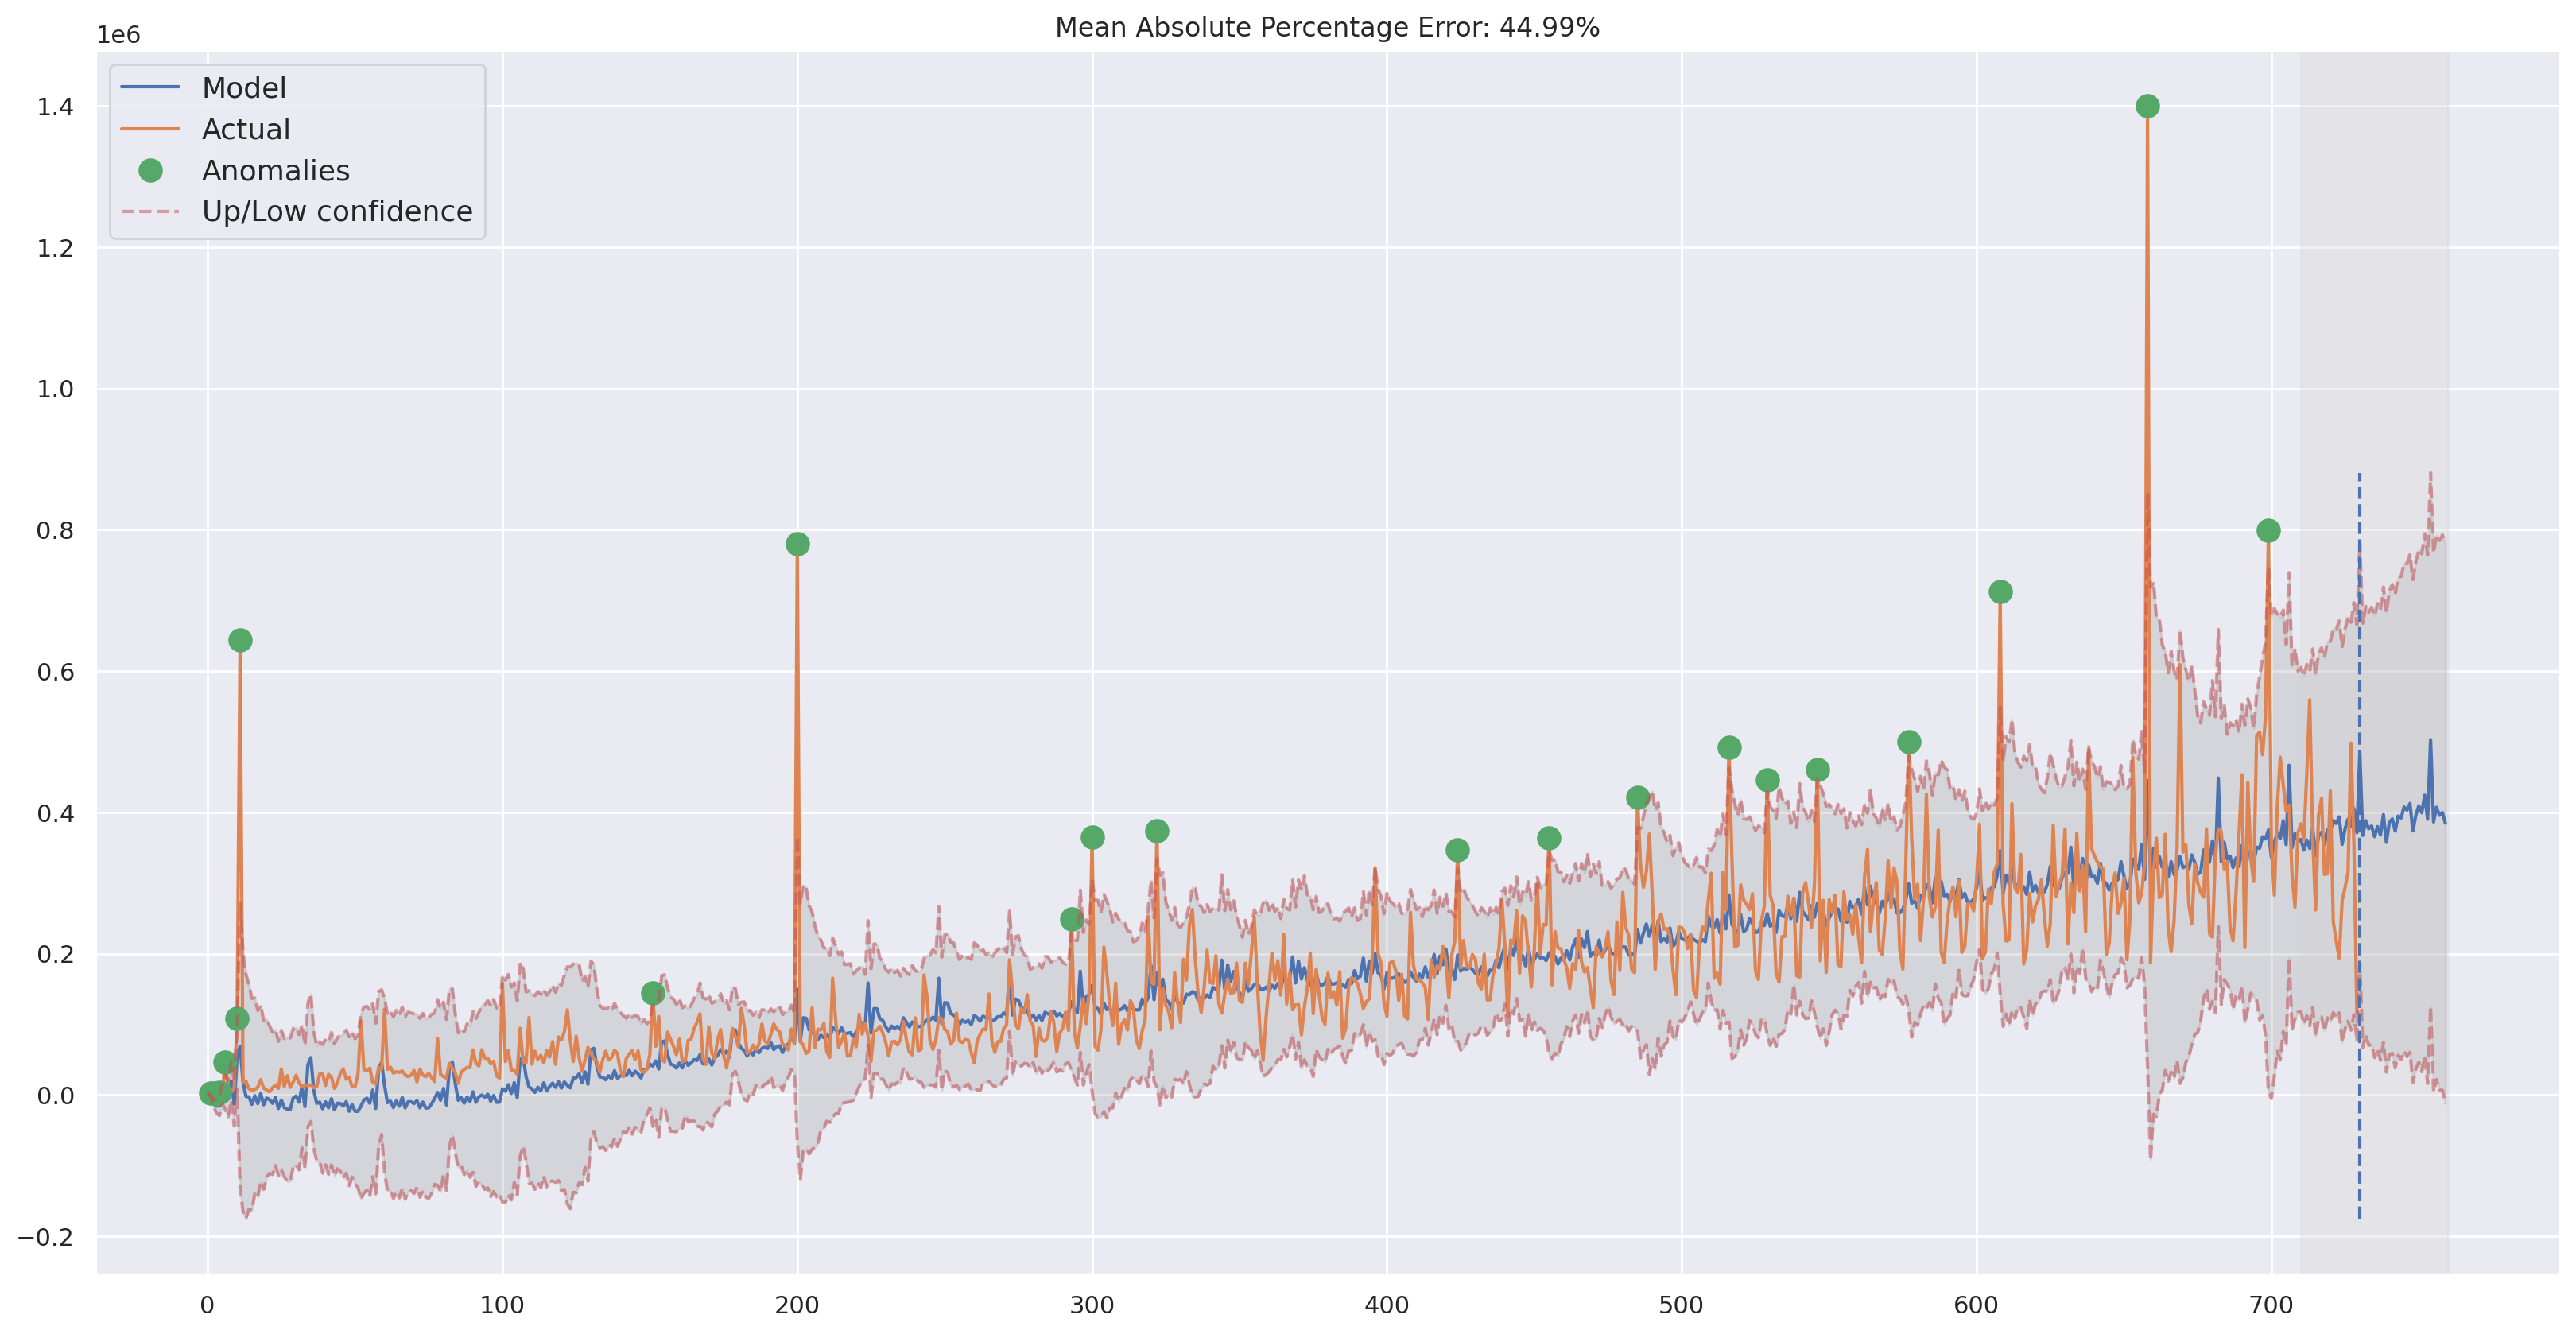

In [21]:
plotHoltWinters(Dollar_series, plot_intervals=True, plot_anomalies=True)

In [22]:
# Time Series Lags
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(Dollar_series.copy())
data.columns = ["y"]

In [23]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 24):
    data["lag_{}".format(i)] = data.y.shift(i)

In [24]:
# take a look at the new dataframe
data.tail(5)

y      lag_6      lag_7      lag_8      lag_9     lag_10  \
time                                                                           
2034-12-27  293766.10  313324.98  312225.70  420394.63  396643.43  261992.24   
2034-12-28  315164.10  430667.55  313324.98  312225.70  420394.63  396643.43   
2034-12-29  498176.35  245067.23  430667.55  313324.98  312225.70  420394.63   
2034-12-30  352553.04  217588.71  245067.23  430667.55  313324.98  312225.70   
2034-12-31  116018.83  193883.71  217588.71  245067.23  430667.55  313324.98   

               lag_11     lag_12     lag_13     lag_14     lag_15     lag_16  \
time                                                                           
2034-12-27  366191.40  559442.39  454086.17  361317.62  383927.25  371273.43   
2034-12-28  261992.24  366191.40  559442.39  454086.17  361317.62  383927.25   
2034-12-29  396643.43  261992.24  366191.40  559442.39  454086.17  361317.62   
2034-12-30  420394.63  396643.43  261992.24  366191.40  559442.39  454086.17   
2034-12-31  312225.70  420394.63  396643.43  261992.24  366191.40  559442.39   

               lag_17     lag_18     lag_19     lag_20     lag_21     lag_22  \
time                                                                           
2034-12-27  265797.56  313705.49  410193.80  401458.89  440476.44  478355.68   
2034-12-28  371273.43  265797.56  313705.49  410193.80  401458.89  440476.44   
2034-12-29  383927.25  371273.43  265797.56  313705.49  410193.80  401458.89   
2034-12-30  361317.62  383927.25  371273.43  265797.56  313705.49  410193.80   
2034-12-31  454086.17  361317.62  383927.25  371273.43  265797.56  313705.49   

               lag_23  
time                   
2034-12-27  408371.54  
2034-12-28  478355.68  
2034-12-29  440476.44  
2034-12-30  401458.89  
2034-12-31  410193.80

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2033-01-01 to 2034-12-31
Freq: D
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       730 non-null    float64
 1   lag_6   724 non-null    float64
 2   lag_7   723 non-null    float64
 3   lag_8   722 non-null    float64
 4   lag_9   721 non-null    float64
 5   lag_10  720 non-null    float64
 6   lag_11  719 non-null    float64
 7   lag_12  718 non-null    float64
 8   lag_13  717 non-null    float64
 9   lag_14  716 non-null    float64
 10  lag_15  715 non-null    float64
 11  lag_16  714 non-null    float64
 12  lag_17  713 non-null    float64
 13  lag_18  712 non-null    float64
 14  lag_19  711 non-null    float64
 15  lag_20  710 non-null    float64
 16  lag_21  709 non-null    float64
 17  lag_22  708 non-null    float64
 18  lag_23  707 non-null    float64
dtypes: float64(19)
memory usage: 114.1 KB


In [26]:
# Train New Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [28]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [29]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [30]:
def plotModelResults(
    model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

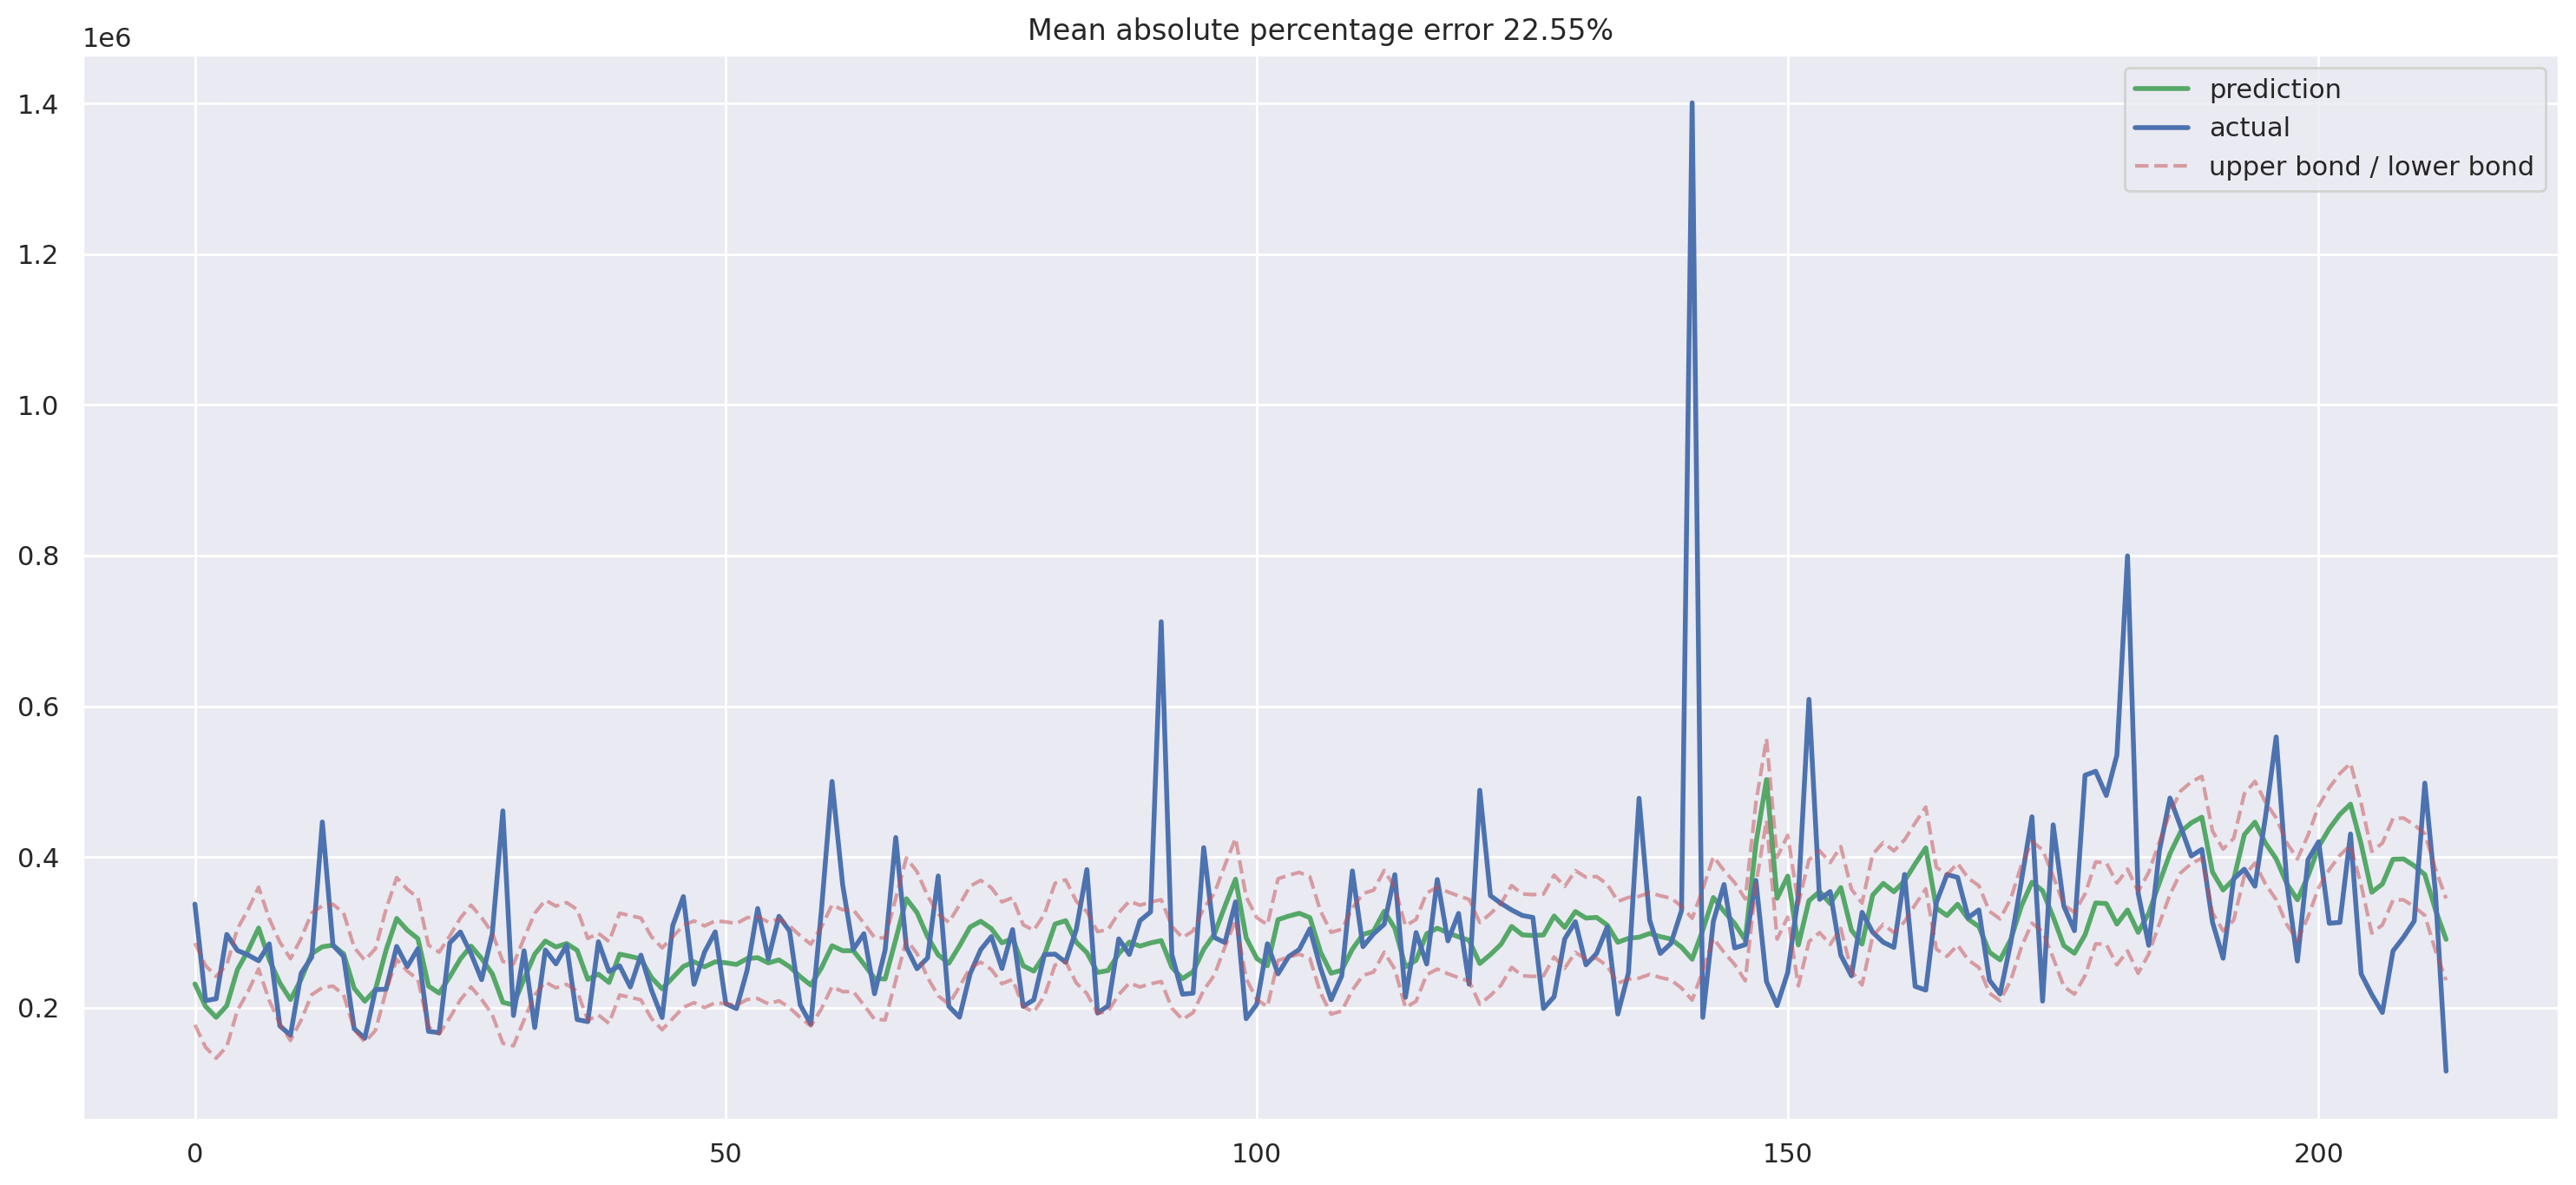

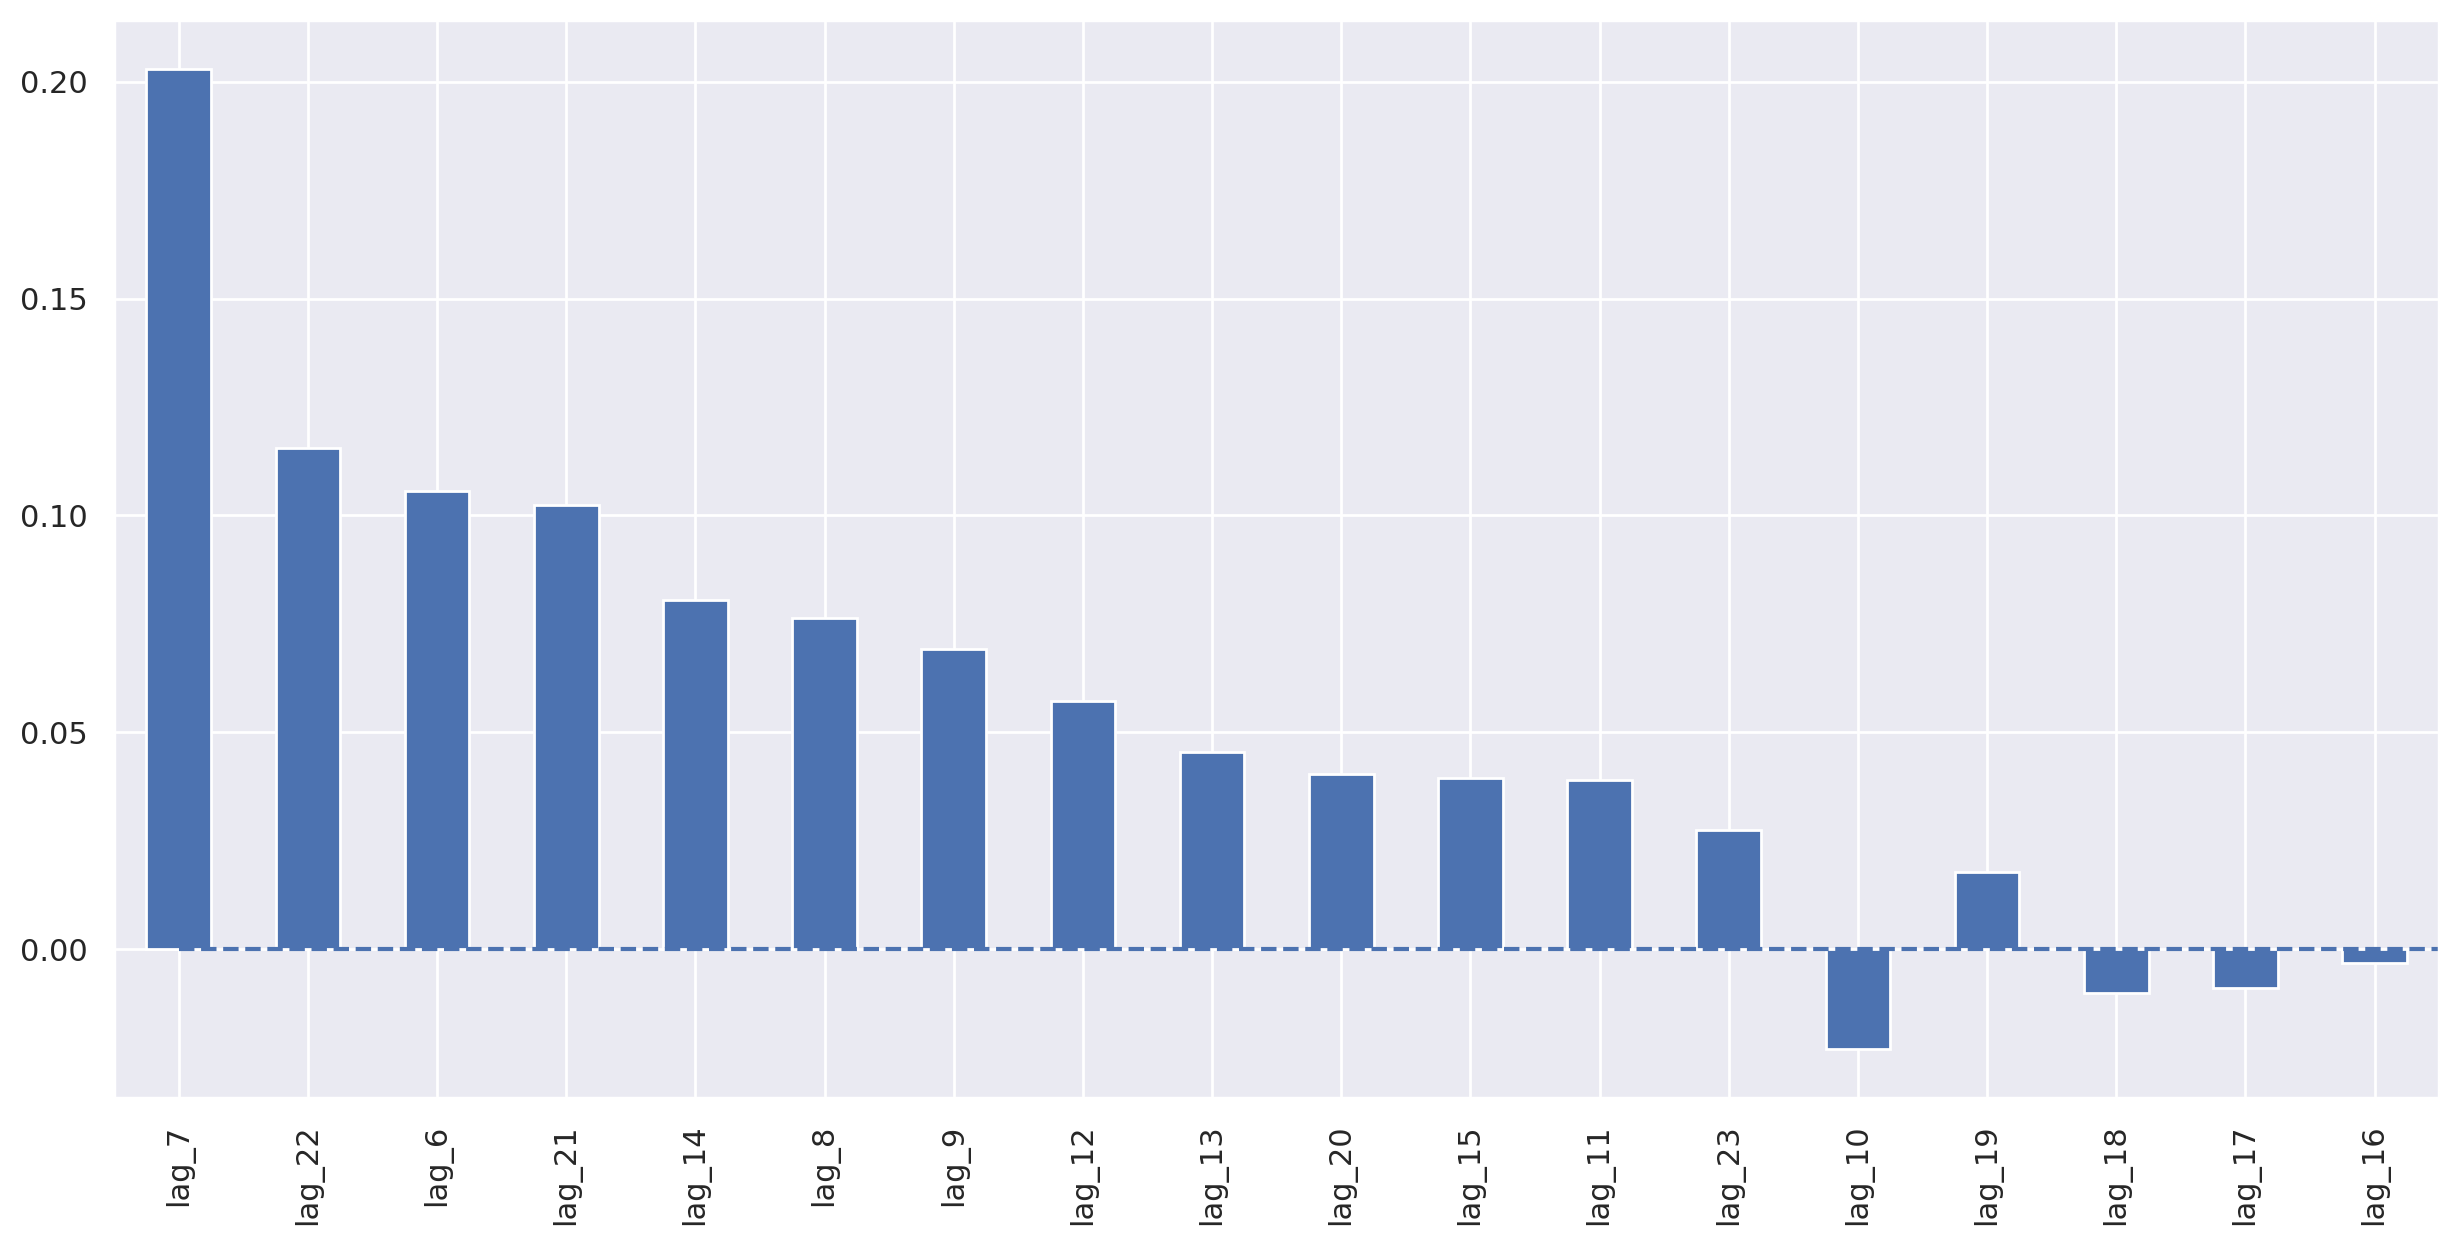

In [31]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [32]:
# Scale Feature Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [33]:
data.tail(5)

y      lag_6      lag_7      lag_8      lag_9     lag_10  \
time                                                                           
2034-12-27  293766.10  313324.98  312225.70  420394.63  396643.43  261992.24   
2034-12-28  315164.10  430667.55  313324.98  312225.70  420394.63  396643.43   
2034-12-29  498176.35  245067.23  430667.55  313324.98  312225.70  420394.63   
2034-12-30  352553.04  217588.71  245067.23  430667.55  313324.98  312225.70   
2034-12-31  116018.83  193883.71  217588.71  245067.23  430667.55  313324.98   

               lag_11     lag_12     lag_13     lag_14     lag_15     lag_16  \
time                                                                           
2034-12-27  366191.40  559442.39  454086.17  361317.62  383927.25  371273.43   
2034-12-28  261992.24  366191.40  559442.39  454086.17  361317.62  383927.25   
2034-12-29  396643.43  261992.24  366191.40  559442.39  454086.17  361317.62   
2034-12-30  420394.63  396643.43  261992.24  366191.40  559442.39  454086.17   
2034-12-31  312225.70  420394.63  396643.43  261992.24  366191.40  559442.39   

               lag_17     lag_18     lag_19     lag_20     lag_21     lag_22  \
time                                                                           
2034-12-27  265797.56  313705.49  410193.80  401458.89  440476.44  478355.68   
2034-12-28  371273.43  265797.56  313705.49  410193.80  401458.89  440476.44   
2034-12-29  383927.25  371273.43  265797.56  313705.49  410193.80  401458.89   
2034-12-30  361317.62  383927.25  371273.43  265797.56  313705.49  410193.80   
2034-12-31  454086.17  361317.62  383927.25  371273.43  265797.56  313705.49   

               lag_23  
time                   
2034-12-27  408371.54  
2034-12-28  478355.68  
2034-12-29  440476.44  
2034-12-30  401458.89  
2034-12-31  410193.80

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2033-01-01 to 2034-12-31
Freq: D
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       730 non-null    float64
 1   lag_6   724 non-null    float64
 2   lag_7   723 non-null    float64
 3   lag_8   722 non-null    float64
 4   lag_9   721 non-null    float64
 5   lag_10  720 non-null    float64
 6   lag_11  719 non-null    float64
 7   lag_12  718 non-null    float64
 8   lag_13  717 non-null    float64
 9   lag_14  716 non-null    float64
 10  lag_15  715 non-null    float64
 11  lag_16  714 non-null    float64
 12  lag_17  713 non-null    float64
 13  lag_18  712 non-null    float64
 14  lag_19  711 non-null    float64
 15  lag_20  710 non-null    float64
 16  lag_21  709 non-null    float64
 17  lag_22  708 non-null    float64
 18  lag_23  707 non-null    float64
dtypes: float64(19)
memory usage: 114.1 KB


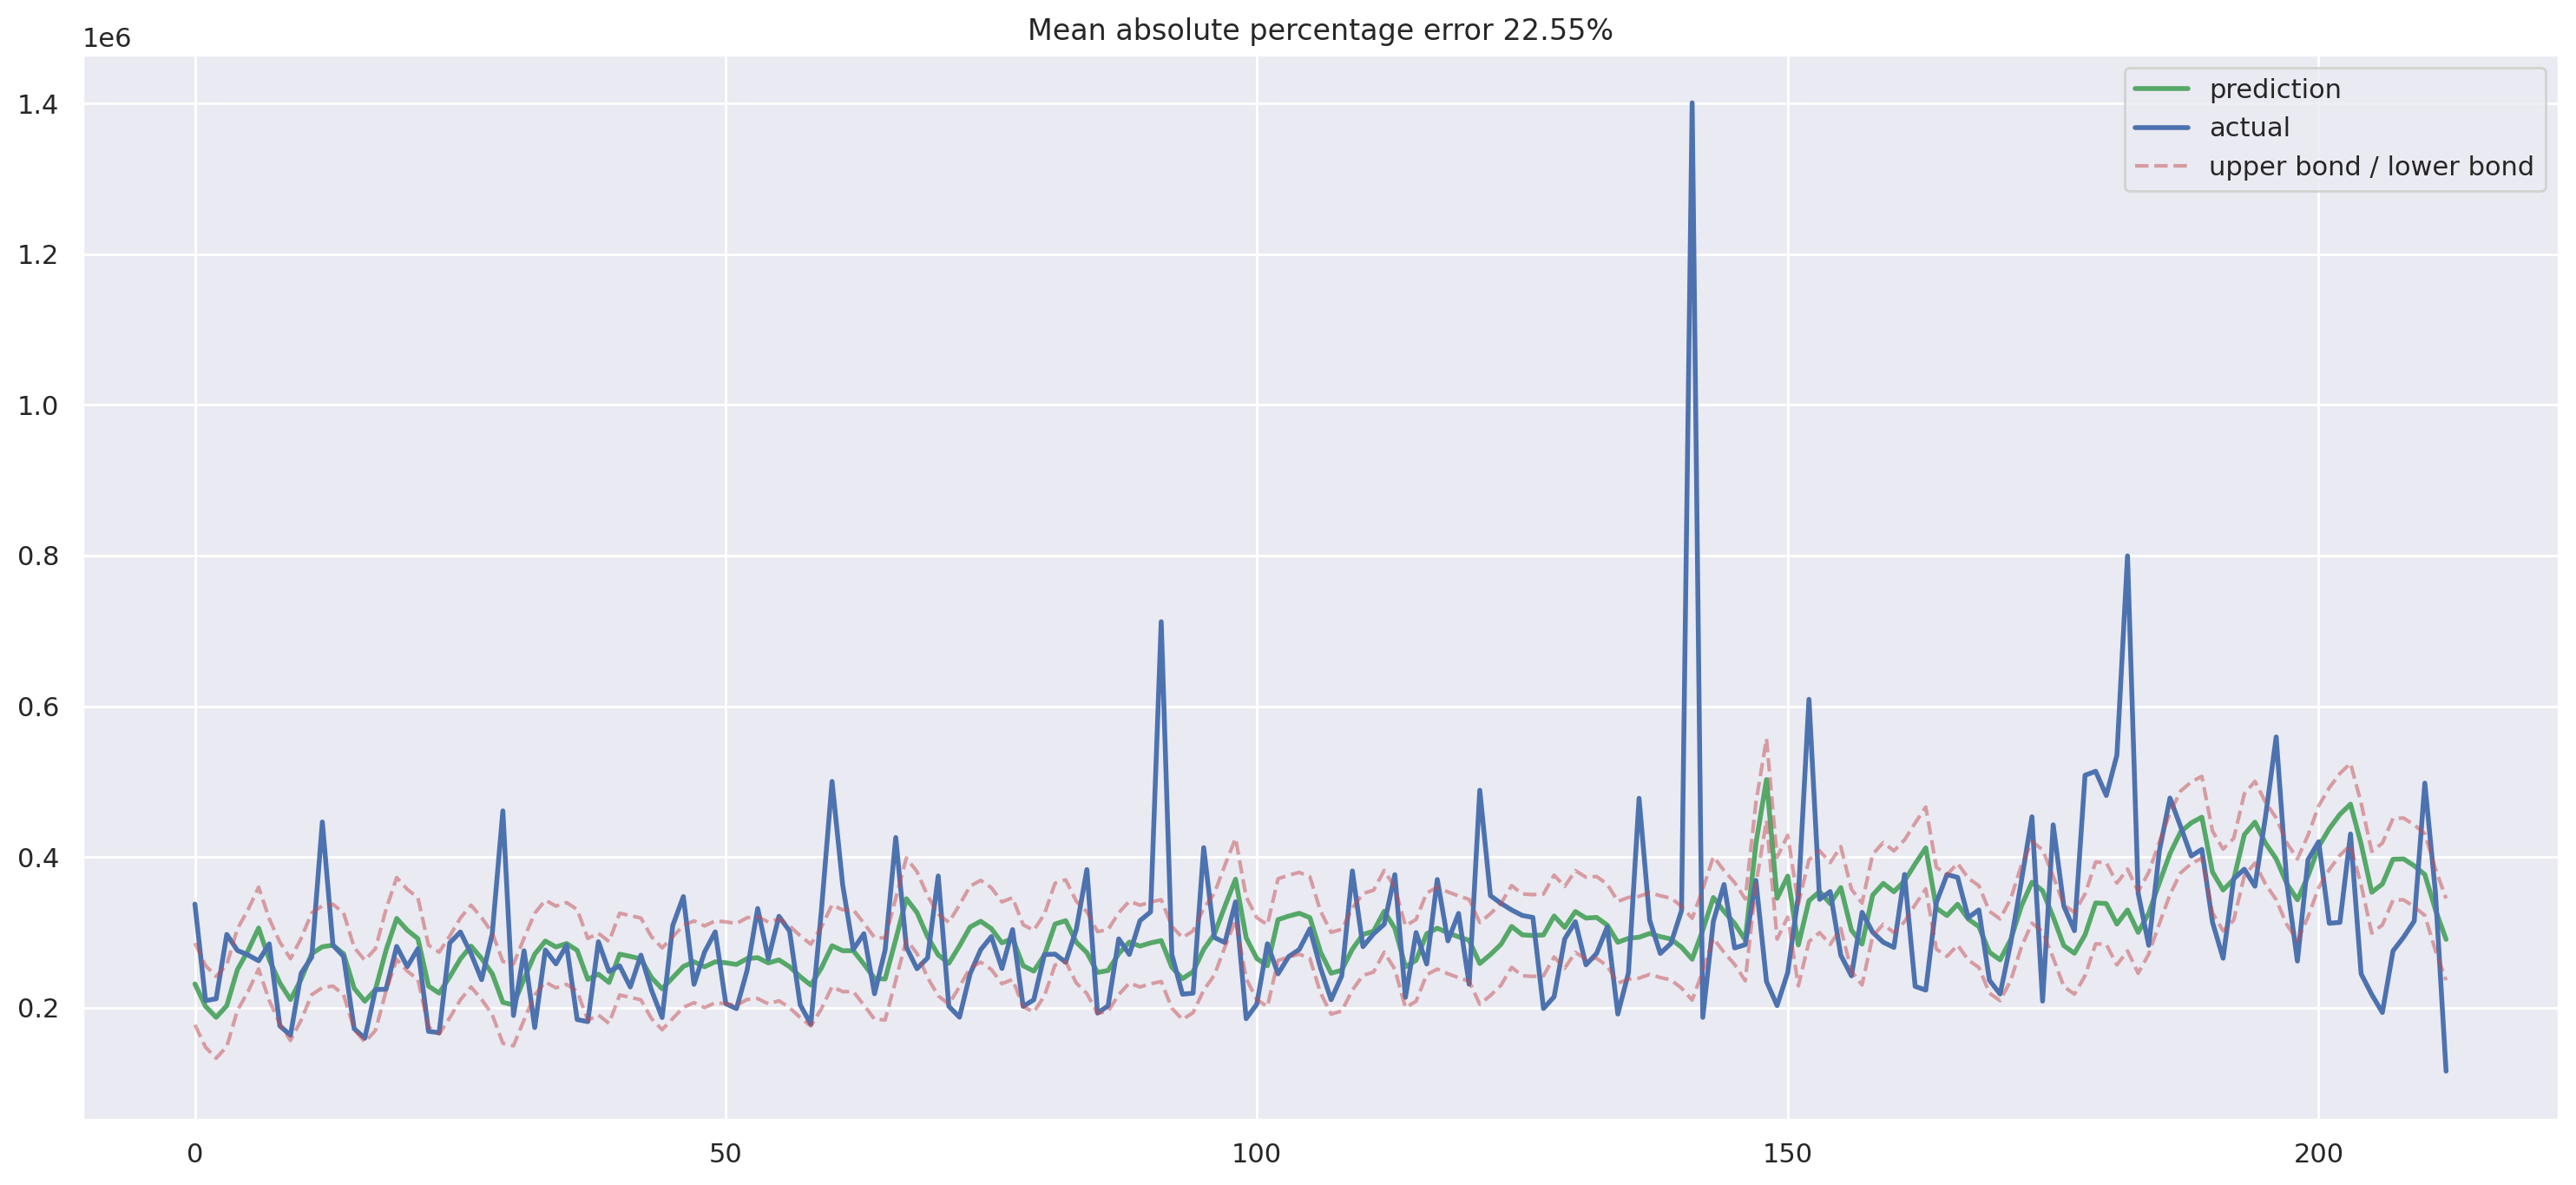

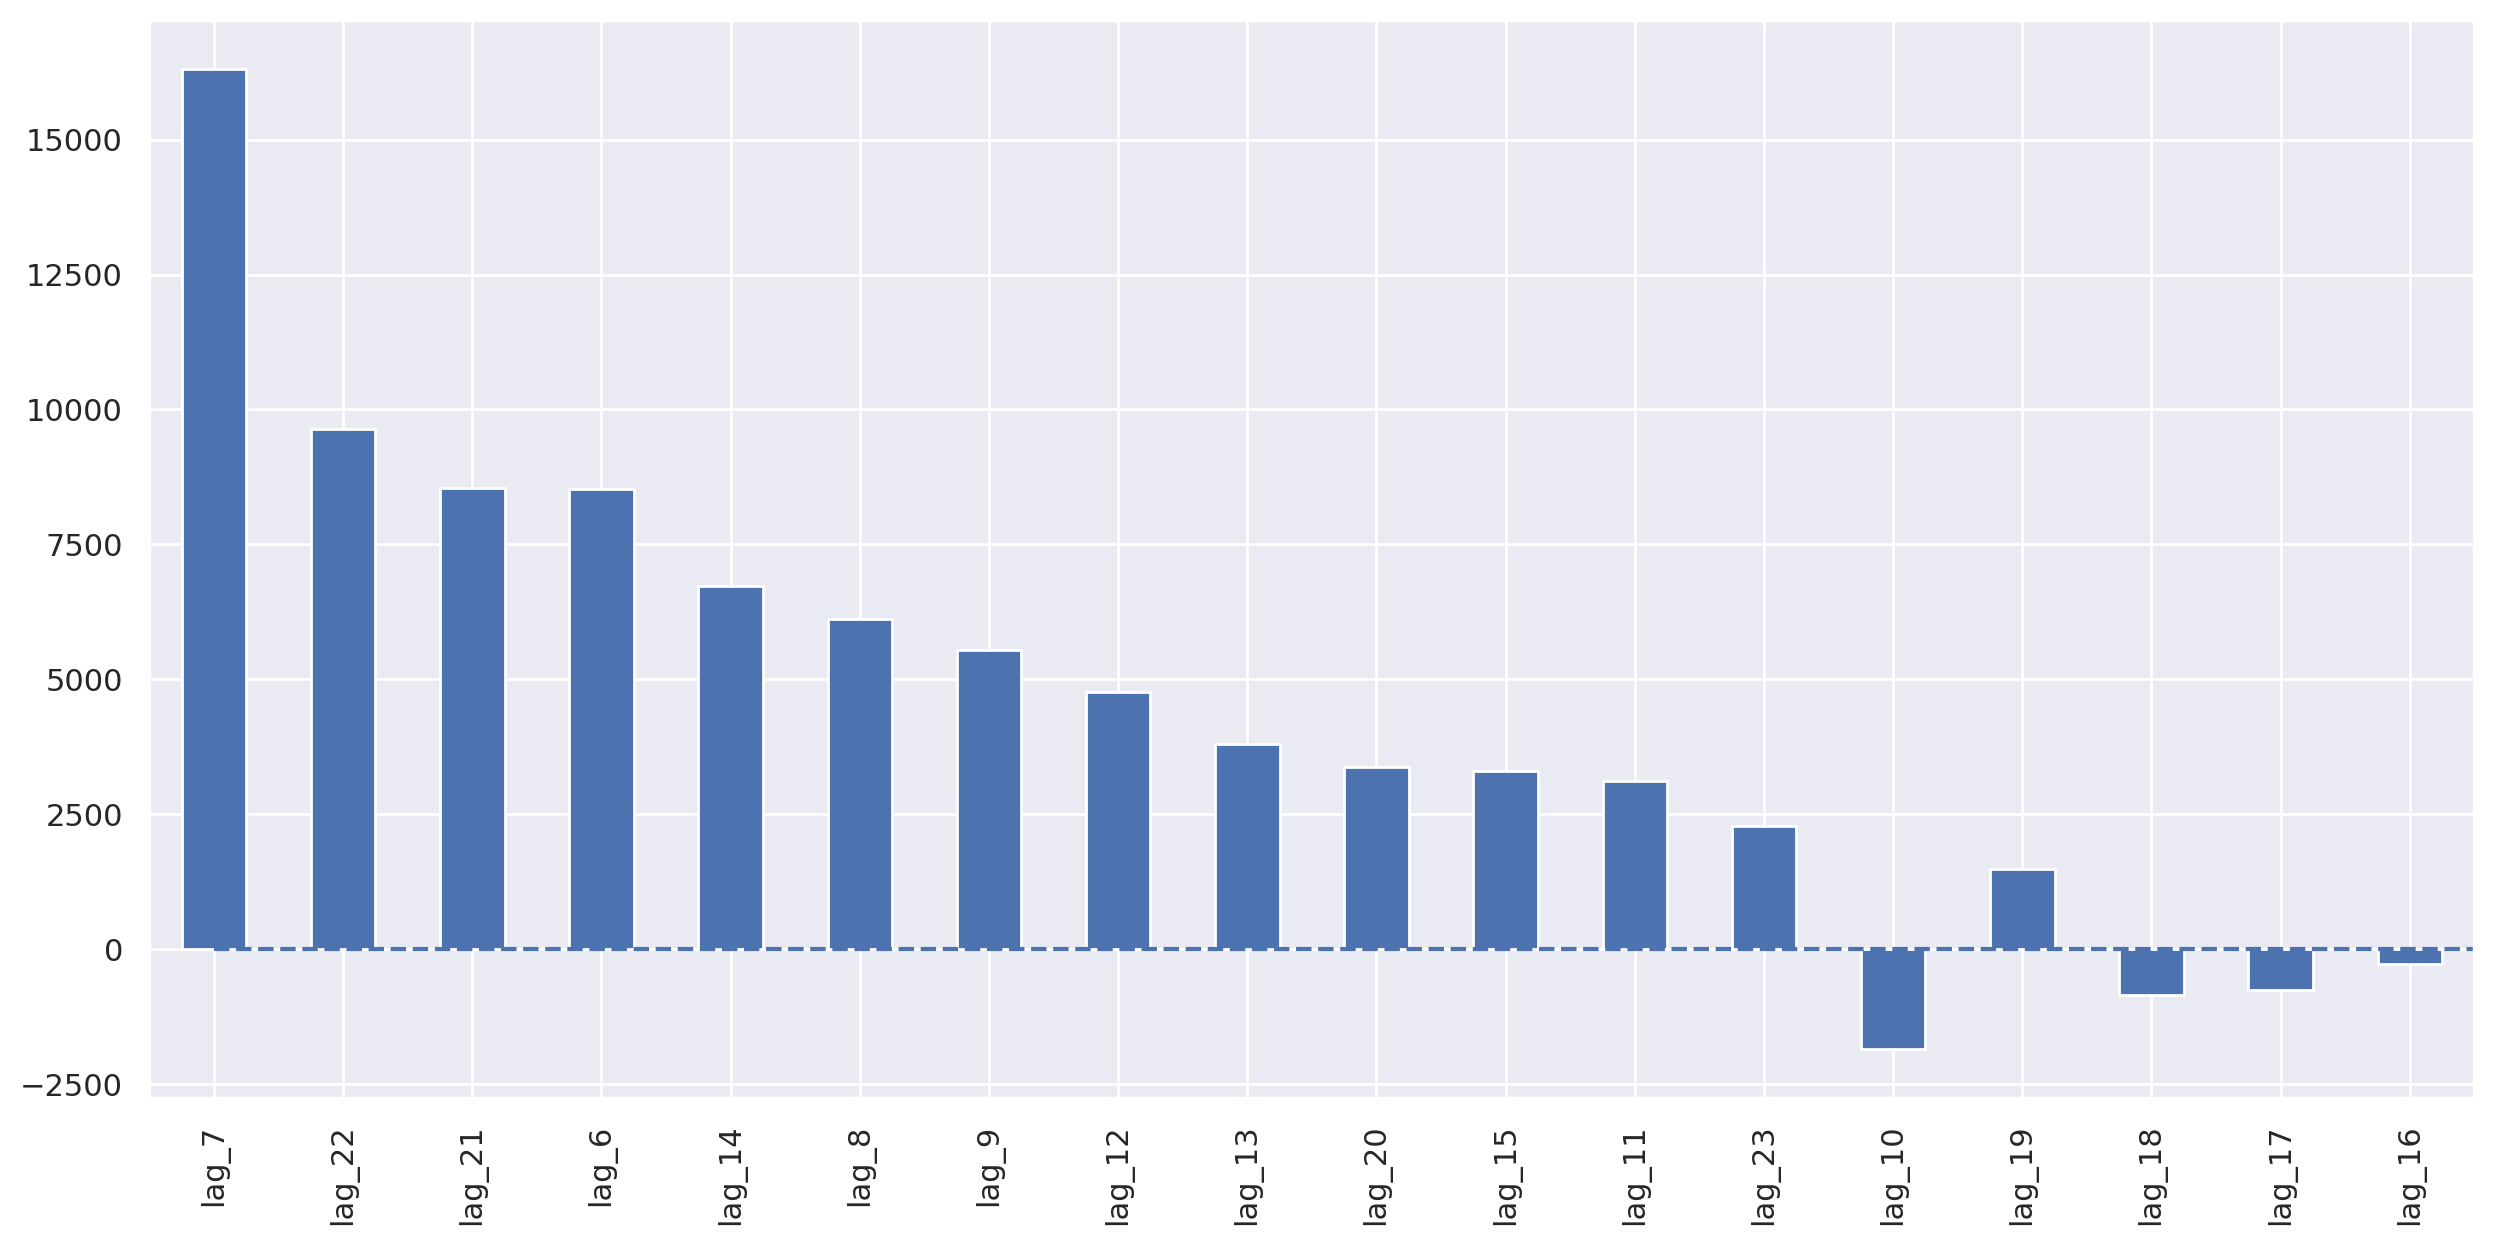

In [35]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [36]:
#Target Encoding
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [37]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable
            example - lag_start = 1 means that the model
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset

    """

    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna()) * (1 - test_size))
        data["weekday_average"] = list(
            map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
        )
        data["hour_average"] = list(
            map(code_mean(data[:test_index], "hour", "y").get, data.hour)
        )

        # drop encoded variables
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(["y"], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(
        X, y, test_size=test_size
    )

    return X_train, X_test, y_train, y_test

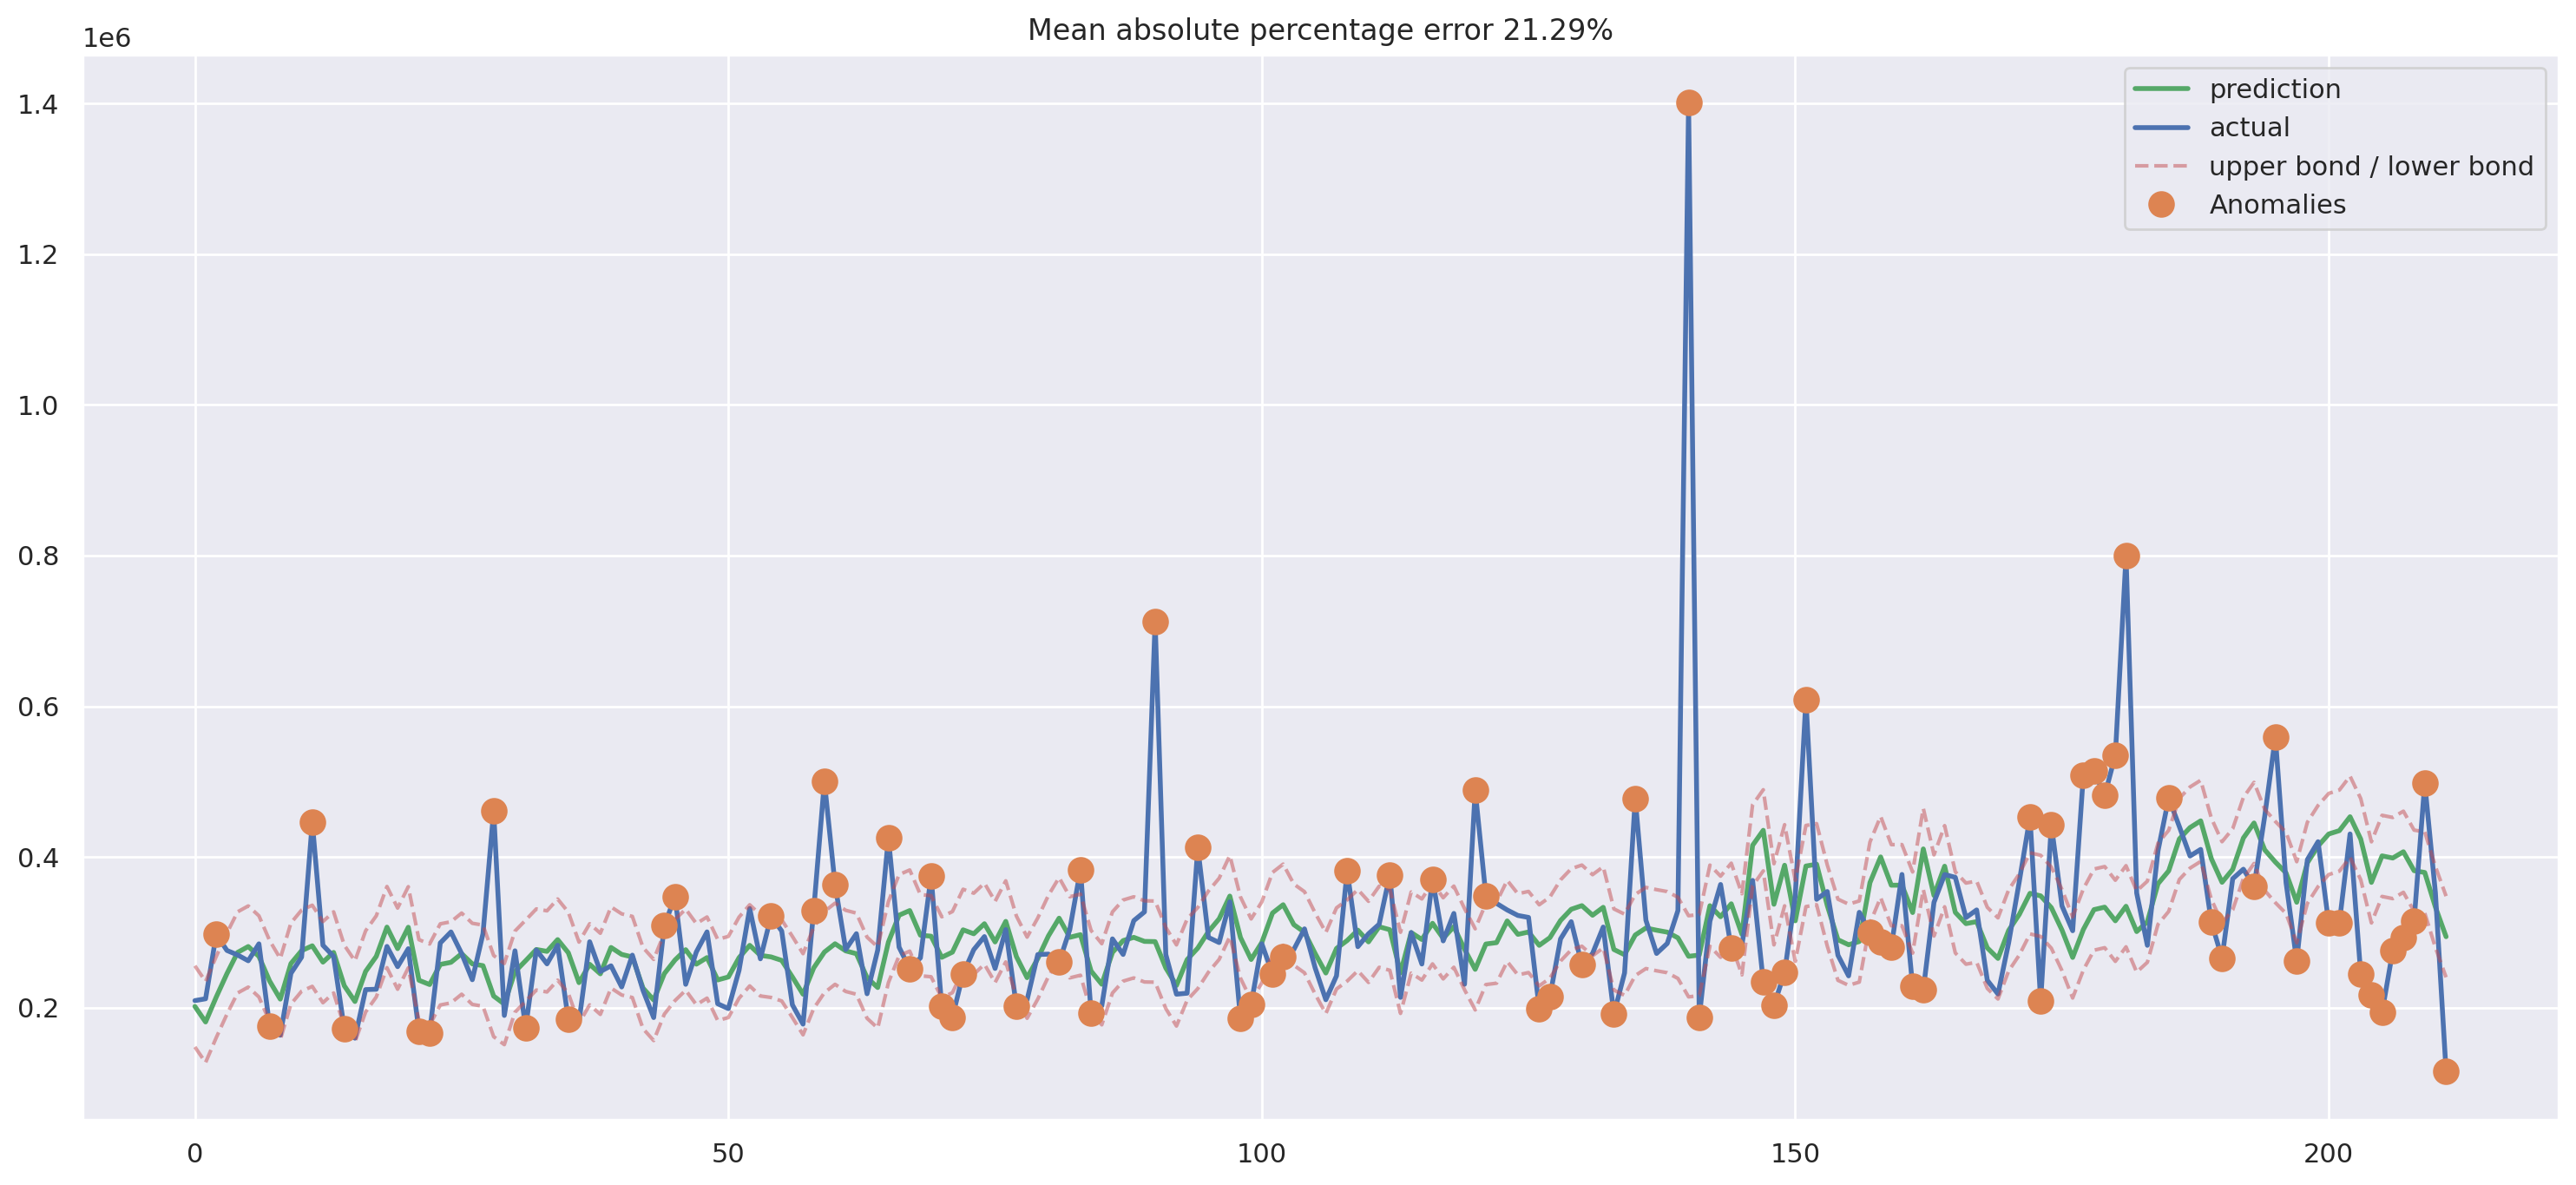

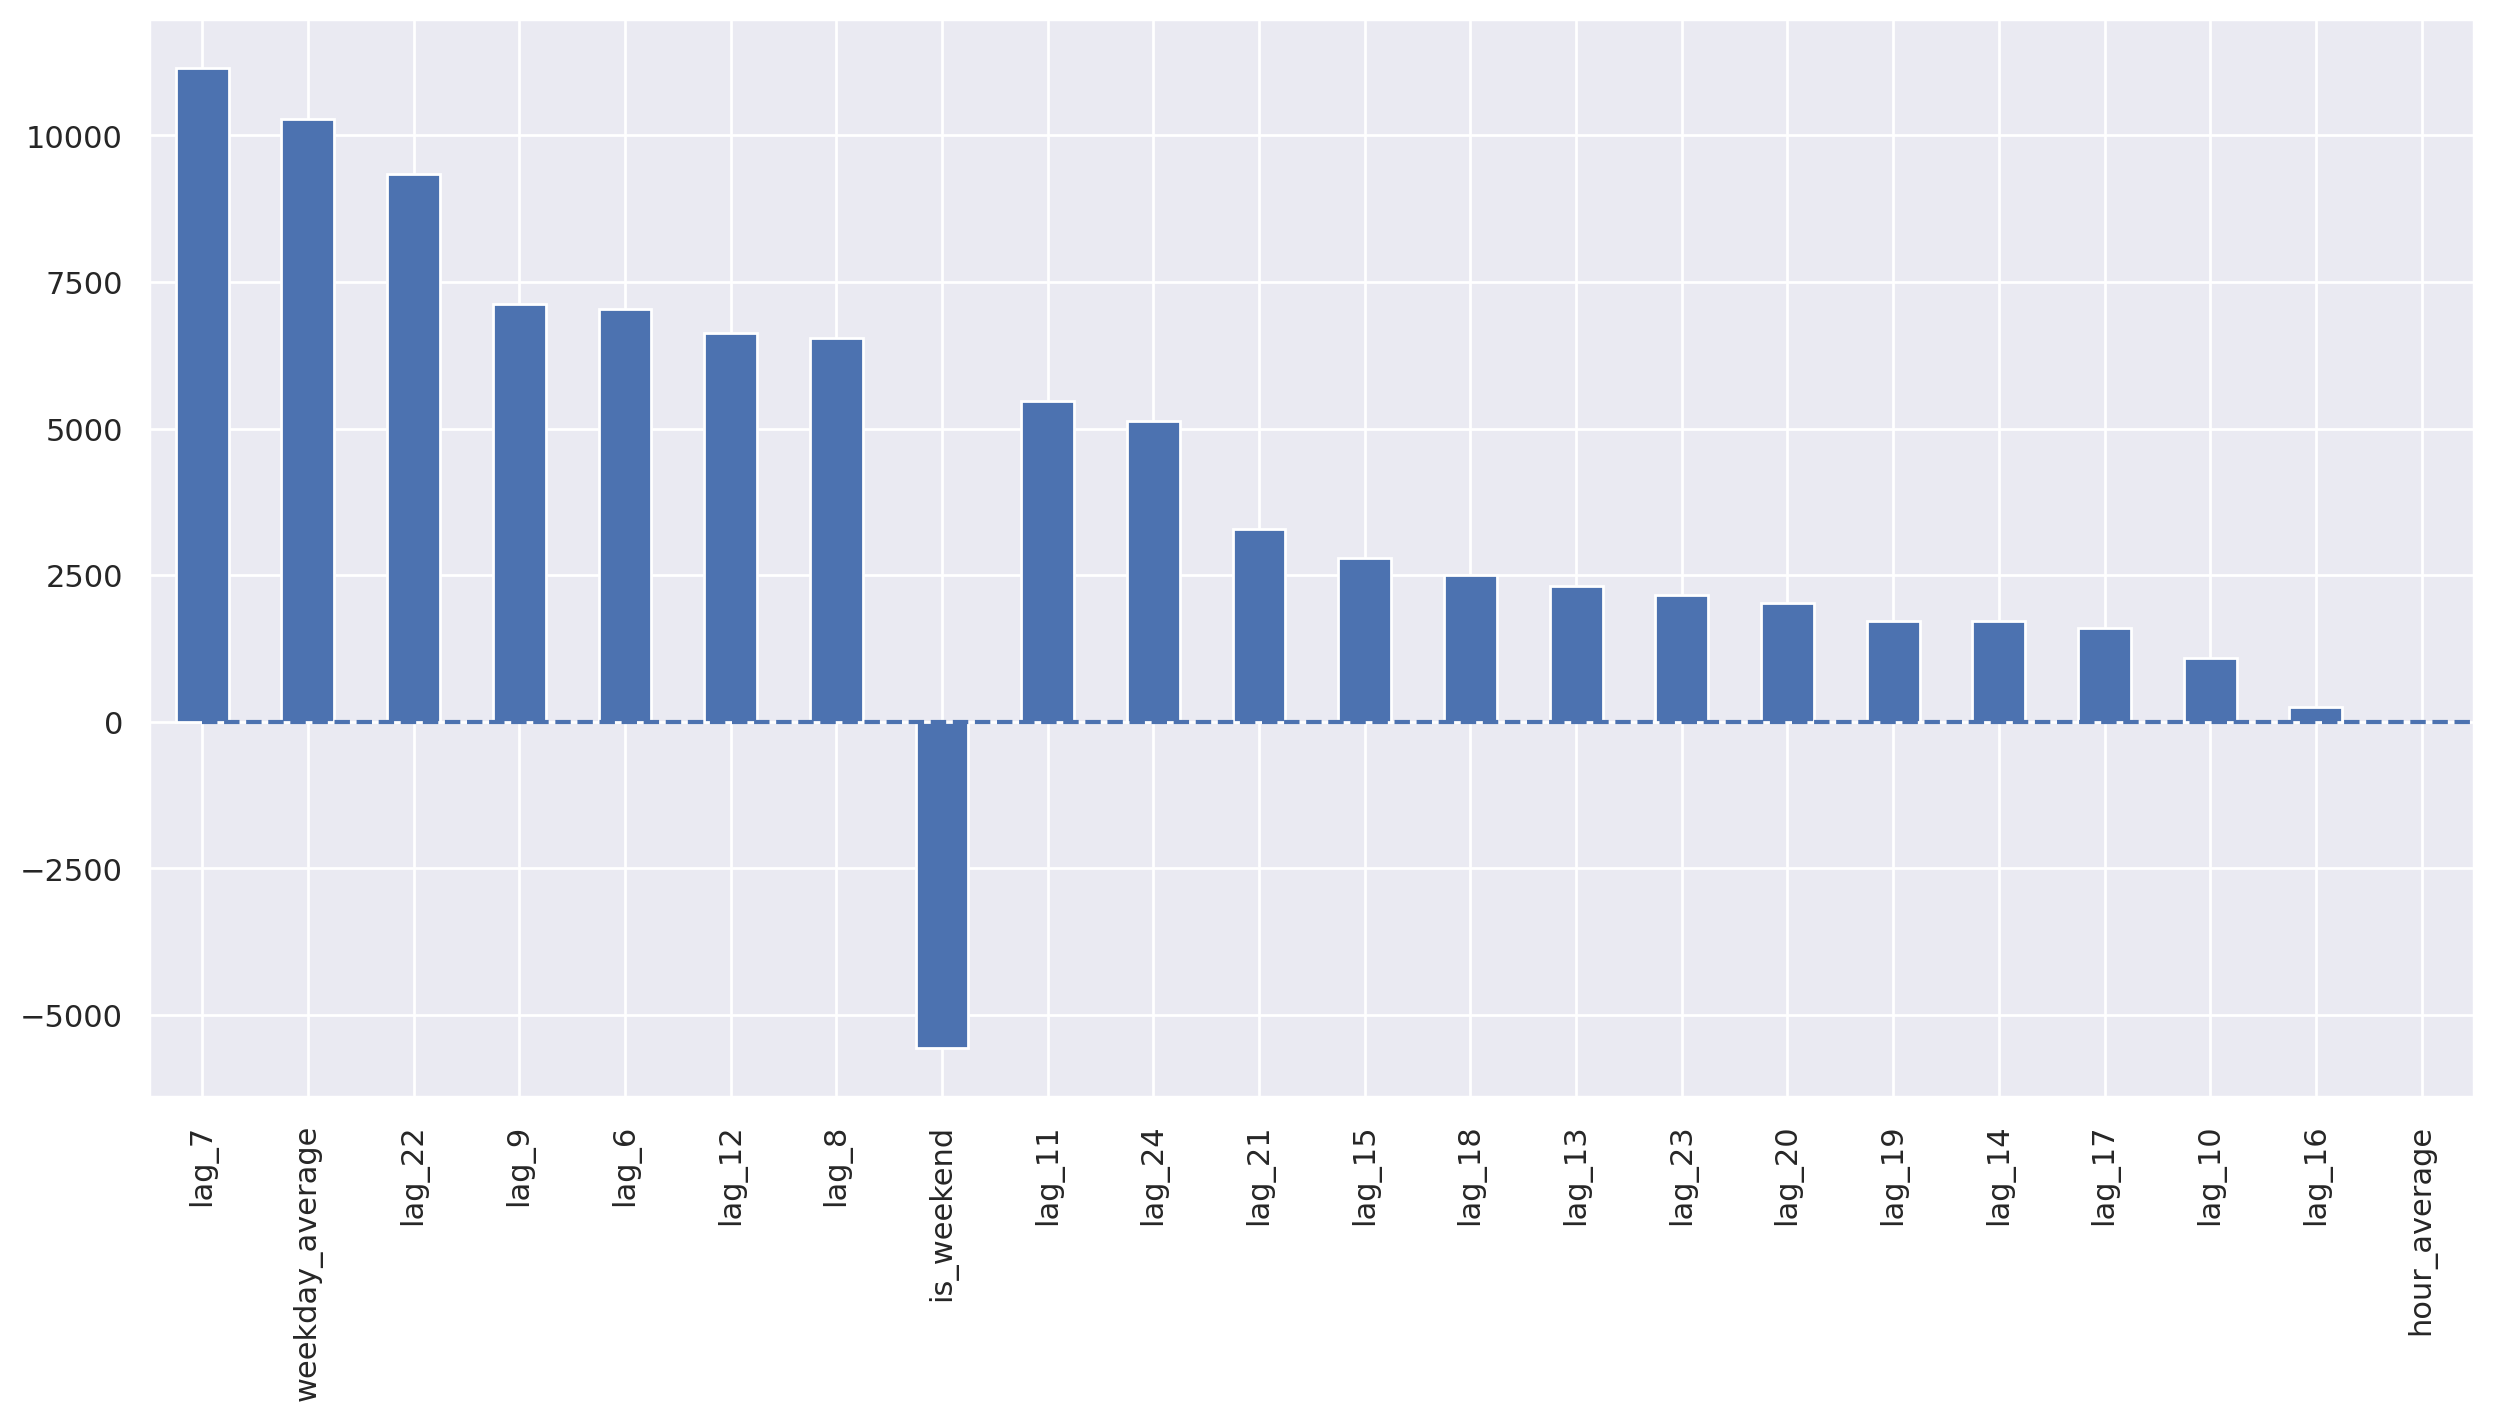

In [40]:
# Drop initial rows with missing values (NaN)
Data = Dollar_series.dropna()
# Split data into training and testing sets
X_train, X_test, y_train, y_test = prepareData(
    Data, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True
)

# Scale Data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


# Make prediction on the test set
y_pred = lr.predict(X_test)

plotModelResults(
    lr,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)
plotCoefficients(lr)

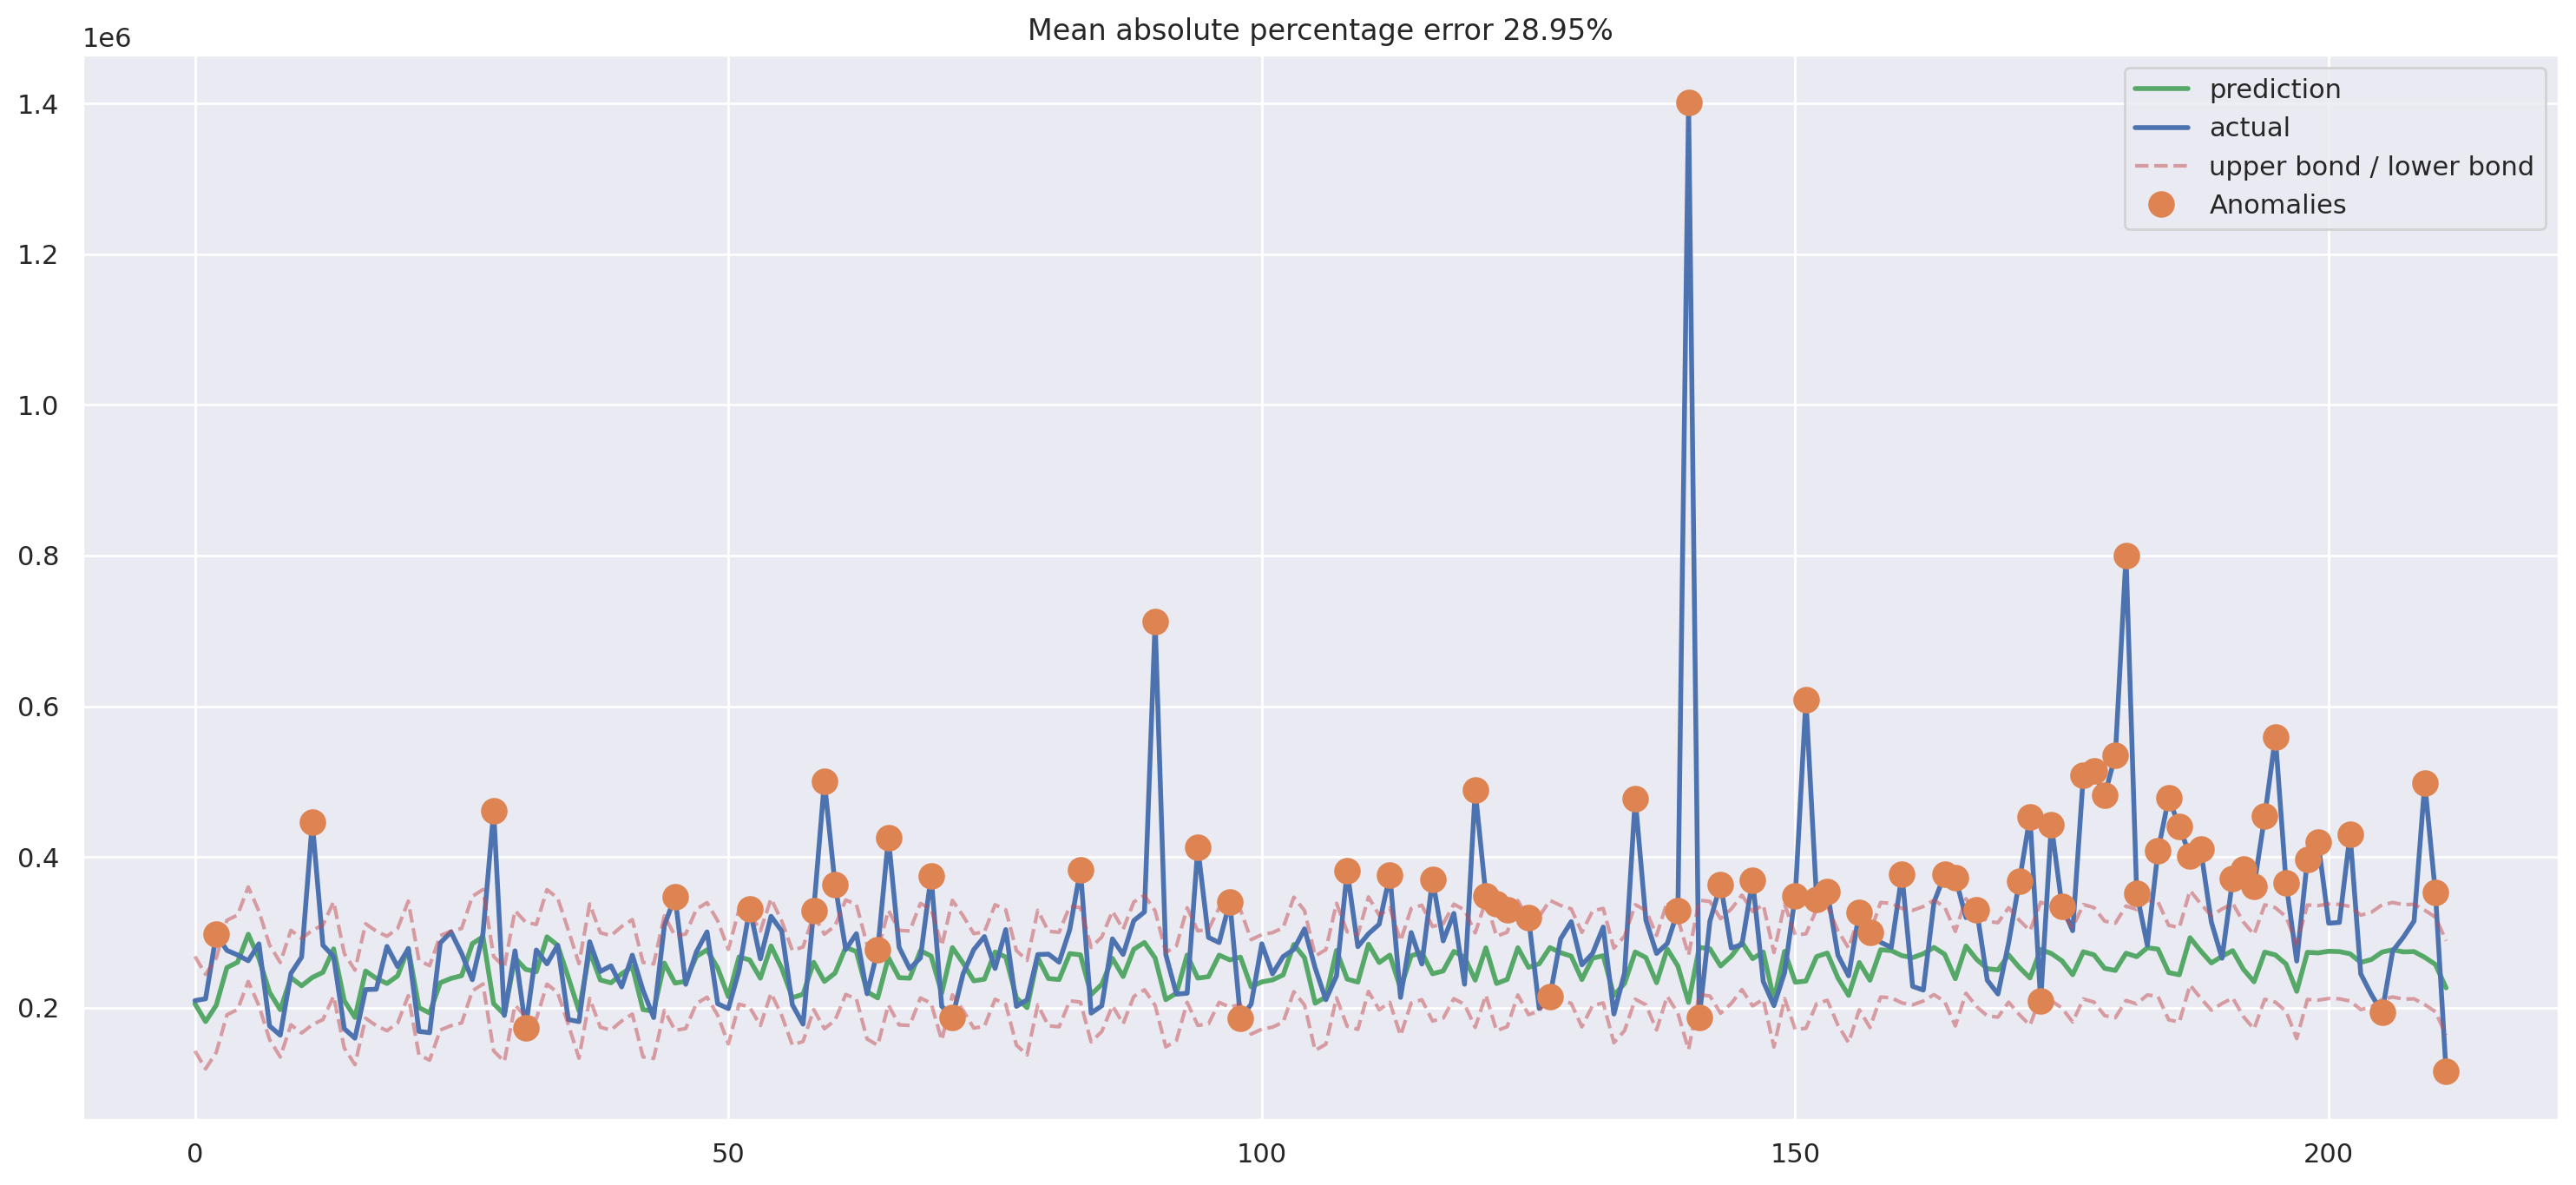

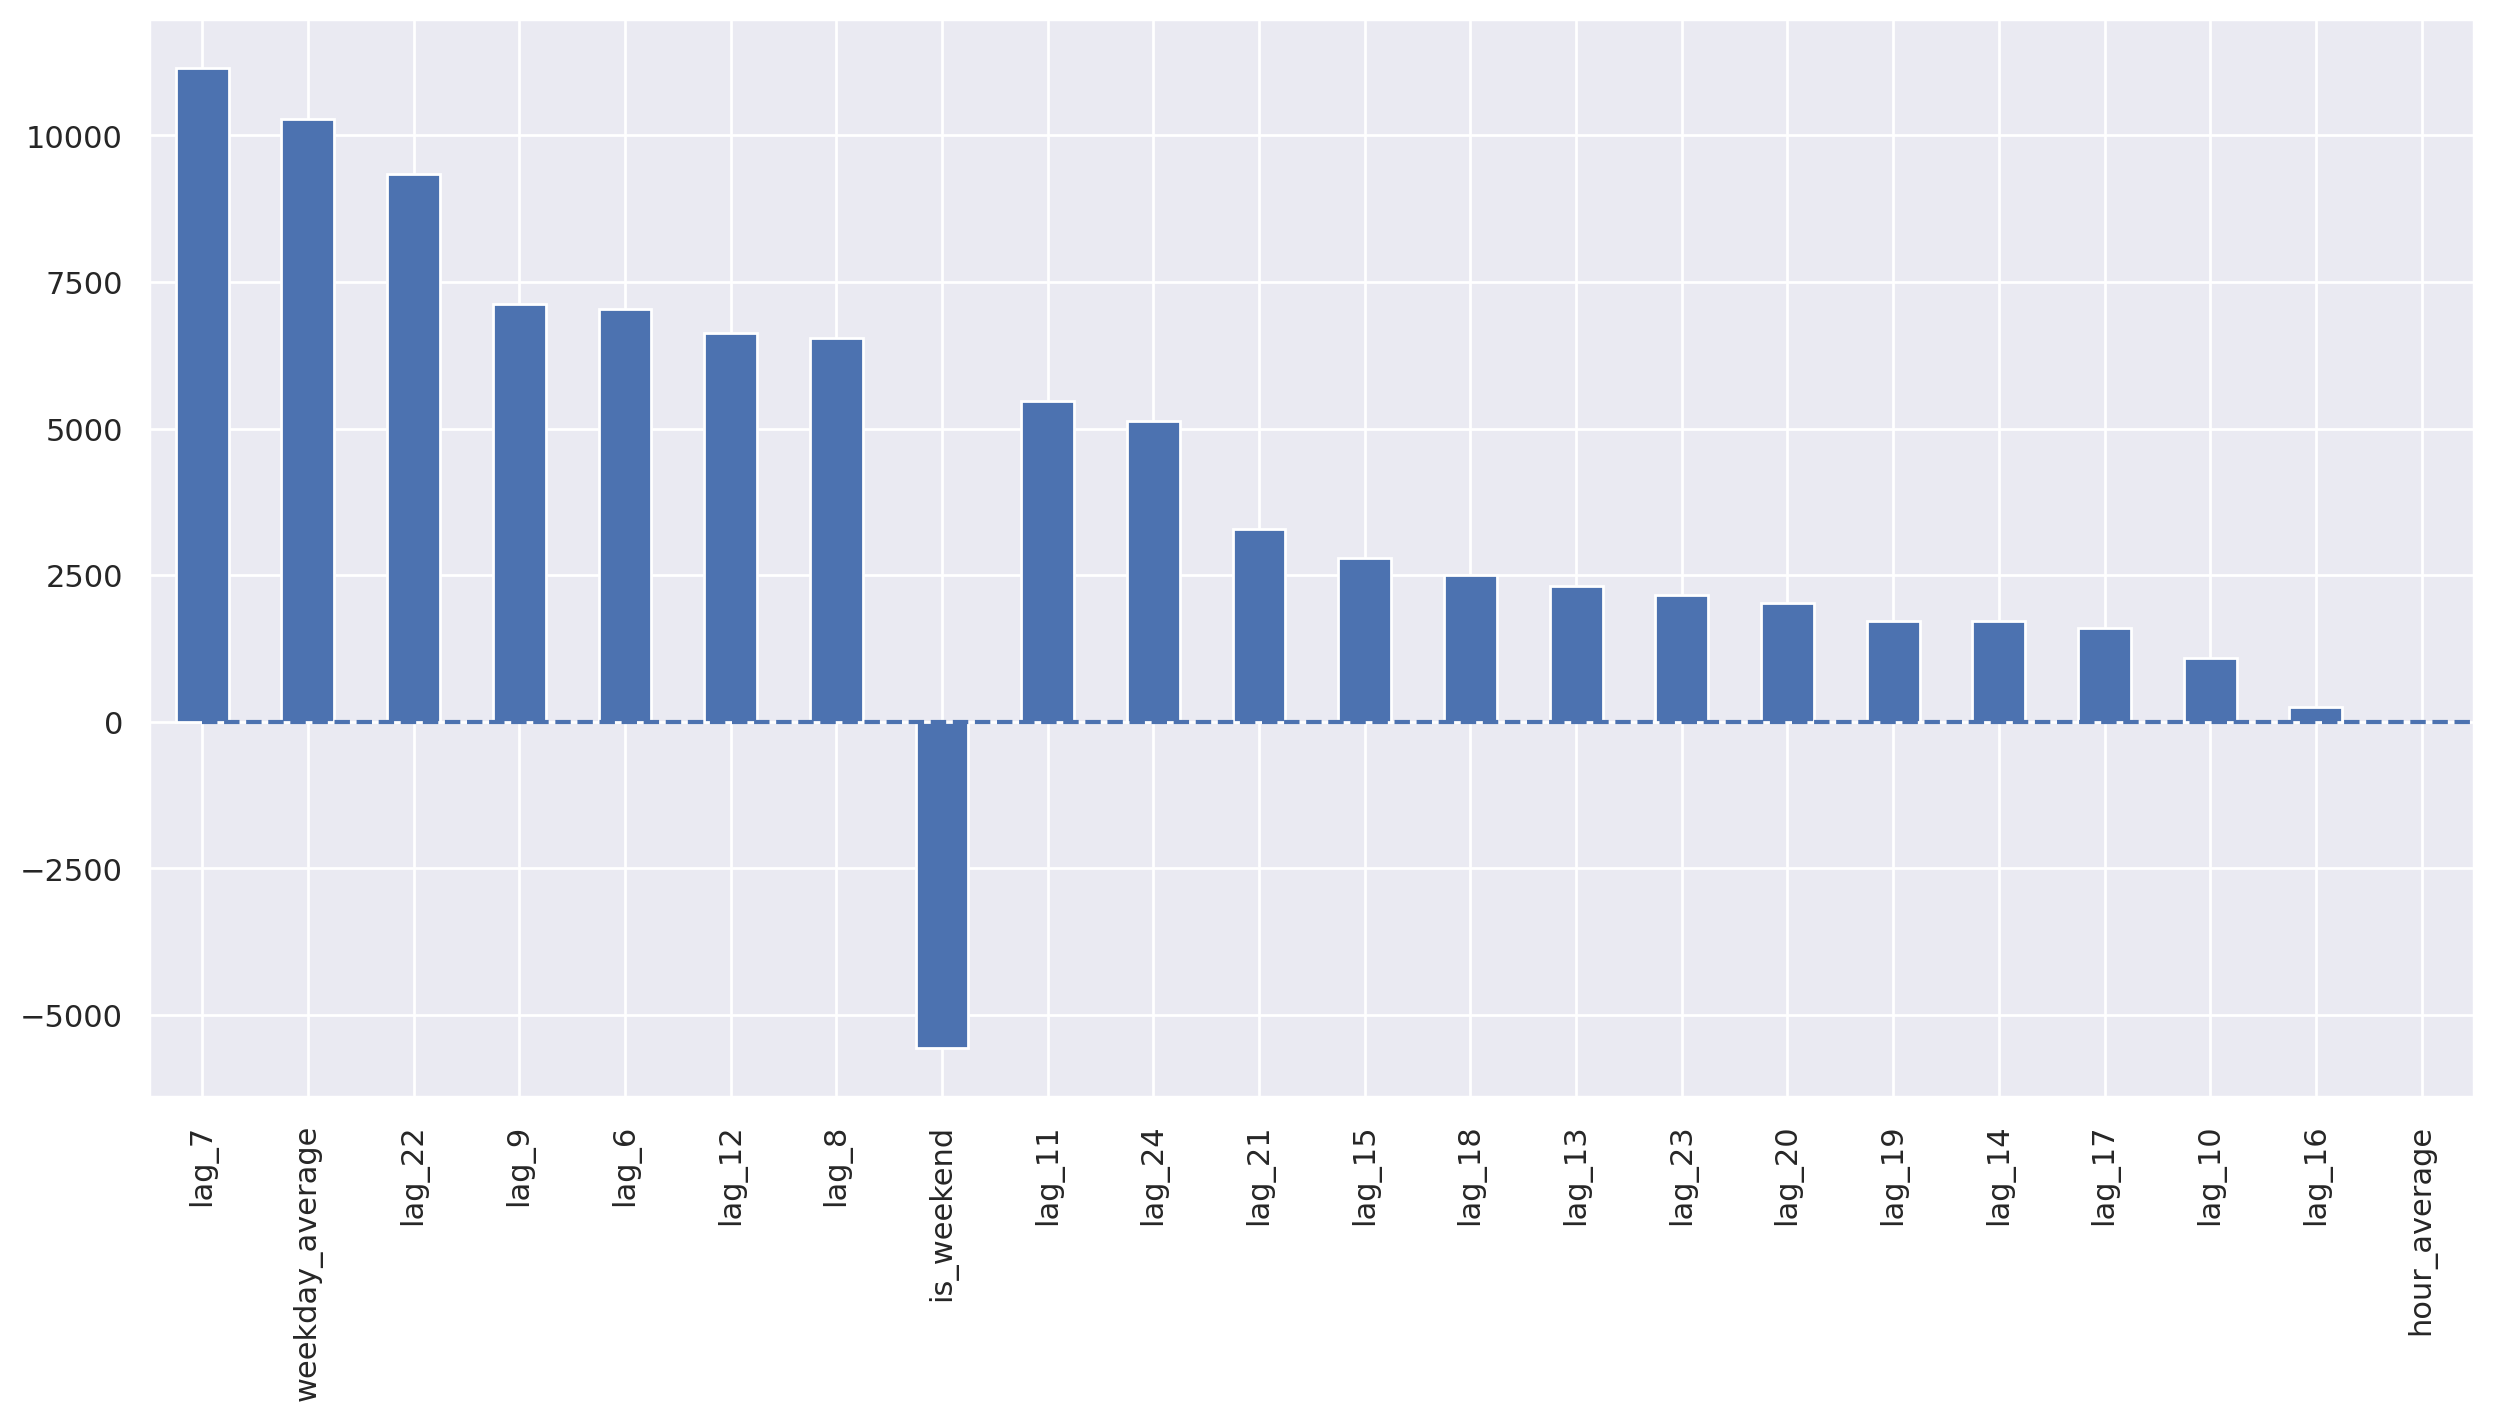

In [45]:
# Now with Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
# Drop initial rows with missing values (NaN)
Data = Dollar_series.dropna()
# Split data into training and testing sets
X_train, X_test, y_train, y_test = prepareData(
    Data, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True
)

# Scale Data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)


# Make prediction on the test set
y_pred = rf.predict(X_test)

plotModelResults(
    rf,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)
plotCoefficients(lr)

In [ ]:
# Conclusion: Linear Regression Model performs better than Random Forest Model

In [ ]:
# Installing Prophet
#!pip install fbprophet
!pip install Prophet
import warnings
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

%matplotlib inline

In [ ]:
# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")].sort_values(by=['time'])

In [ ]:
X.head()

lag_6     lag_7     lag_8     lag_9    lag_10    lag_11  \
time                                                                     
2033-01-24  19194.69  18953.62  11087.61  15817.95  41119.03  34005.18   
2033-01-25  32943.04  19194.69  18953.62  11087.61  15817.95  41119.03   
2033-01-26  18733.76  32943.04  19194.69  18953.62  11087.61  15817.95   
2033-01-27  18221.52  18733.76  32943.04  19194.69  18953.62  11087.61   
2033-01-28  27234.13  18221.52  18733.76  32943.04  19194.69  18953.62   

                lag_12      lag_13      lag_14      lag_15      lag_16  \
time                                                                     
2033-01-24  1210293.14   241898.77    20481.44     9100.92    10977.77   
2033-01-25    34005.18  1210293.14   241898.77    20481.44     9100.92   
2033-01-26    41119.03    34005.18  1210293.14   241898.77    20481.44   
2033-01-27    15817.95    41119.03    34005.18  1210293.14   241898.77   
2033-01-28    11087.61    15817.95    41119.03    34005.18  1210293.14   

               lag_17    lag_18    lag_19    lag_20    lag_21    lag_22  \
time                                                                      
2033-01-24   92925.77  11055.98  10016.21   4851.11   6283.53   4758.62   
2033-01-25   10977.77  92925.77  11055.98  10016.21   4851.11   6283.53   
2033-01-26    9100.92  10977.77  92925.77  11055.98  10016.21   4851.11   
2033-01-27   20481.44   9100.92  10977.77  92925.77  11055.98  10016.21   
2033-01-28  241898.77  20481.44   9100.92  10977.77  92925.77  11055.98   

              lag_23  
time                  
2033-01-24   4415.40  
2033-01-25   4758.62  
2033-01-26   6283.53  
2033-01-27   4851.11  
2033-01-28  10016.21

In [ ]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Initialize plotly
init_notebook_mode(connected=True)

In [ ]:
X.head()

lag_6     lag_7     lag_8     lag_9    lag_10    lag_11  \
time                                                                     
2033-01-24  19194.69  18953.62  11087.61  15817.95  41119.03  34005.18   
2033-01-25  32943.04  19194.69  18953.62  11087.61  15817.95  41119.03   
2033-01-26  18733.76  32943.04  19194.69  18953.62  11087.61  15817.95   
2033-01-27  18221.52  18733.76  32943.04  19194.69  18953.62  11087.61   
2033-01-28  27234.13  18221.52  18733.76  32943.04  19194.69  18953.62   

                lag_12      lag_13      lag_14      lag_15      lag_16  \
time                                                                     
2033-01-24  1210293.14   241898.77    20481.44     9100.92    10977.77   
2033-01-25    34005.18  1210293.14   241898.77    20481.44     9100.92   
2033-01-26    41119.03    34005.18  1210293.14   241898.77    20481.44   
2033-01-27    15817.95    41119.03    34005.18  1210293.14   241898.77   
2033-01-28    11087.61    15817.95    41119.03    34005.18  1210293.14   

               lag_17    lag_18    lag_19    lag_20    lag_21    lag_22  \
time                                                                      
2033-01-24   92925.77  11055.98  10016.21   4851.11   6283.53   4758.62   
2033-01-25   10977.77  92925.77  11055.98  10016.21   4851.11   6283.53   
2033-01-26    9100.92  10977.77  92925.77  11055.98  10016.21   4851.11   
2033-01-27   20481.44   9100.92  10977.77  92925.77  11055.98  10016.21   
2033-01-28  241898.77  20481.44   9100.92  10977.77  92925.77  11055.98   

              lag_23  
time                  
2033-01-24   4415.40  
2033-01-25   4758.62  
2033-01-26   6283.53  
2033-01-27   4851.11  
2033-01-28  10016.21

In [ ]:
#df = X.reset_index()
df = y.reset_index()
df.head()

time         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [ ]:
# Conver datafreame to the format requred by Prophet
#df.columns = ['ds','lag_6','lag_7','lag_8','lag_9','lag_10','lag_11','lag_12','lag_13','lag_14','lag_15','lag_16','lag_17','lag_18','lag_19','lag_20','lag_21','lag_22','lag_23']
df.columns = ["ds",'y']
df.tail(n=3)

ds          y
704 2034-12-29  984672.08
705 2034-12-30  668559.95
706 2034-12-31  208533.08

In [ ]:
y

time
2033-01-24     30777.09
2033-01-25     21963.14
2033-01-26     72914.78
2033-01-27     20217.99
2033-01-28     36659.05
                ...    
2034-12-27    688573.47
2034-12-28    750020.80
2034-12-29    984672.08
2034-12-30    668559.95
2034-12-31    208533.08
Freq: D, Name: y, Length: 707, dtype: float64

In [ ]:
# Split dataset into historical part and prediction part.  Remove the last month from the dataset in order to use it later as prediction target
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

ds           y
674 2034-11-29   862086.23
675 2034-11-30   917309.40
676 2034-12-01  1554456.47

In [ ]:
# Create a new Prophet Object.
m=Prophet()
m.fit(train_df);

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo2tgo9k_/paxx8pnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo2tgo9k_/y0q8fomf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77896', 'data', 'file=/tmp/tmpo2tgo9k_/paxx8pnd.json', 'init=/tmp/tmpo2tgo9k_/y0q8fomf.json', 'output', 'file=/tmp/tmpo2tgo9k_/prophet_modelp352xswi/prophet_model-20240307234829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:48:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:48:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
train_df.head()

ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [ ]:
# Crate dataframe which will contain all dates from the history and also extend into the future for those 30 days that we left out before
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

ds
704 2034-12-29
705 2034-12-30
706 2034-12-31

In [ ]:
forecast=m.predict(future)
forecast.tail(n=3)

ds          trend     yhat_lower     yhat_upper    trend_lower  \
704 2034-12-29  709679.152925  586025.169460  937286.968837  709280.036008   
705 2034-12-30  710892.281813  508638.371192  839143.381193  710465.679732   
706 2034-12-31  712105.410701  458635.209176  802116.941166  711642.154259   

       trend_upper  additive_terms  additive_terms_lower  \
704  710083.652348    53533.771706          53533.771706   
705  711321.357011   -35849.787220         -35849.787220   
706  712557.507532   -84002.785243         -84002.785243   

     additive_terms_upper        weekly  weekly_lower  weekly_upper  \
704          53533.771706  53533.771706  53533.771706  53533.771706   
705         -35849.787220 -35849.787220 -35849.787220 -35849.787220   
706         -84002.785243 -84002.785243 -84002.785243 -84002.785243   

     multiplicative_terms  multiplicative_terms_lower  \
704                   0.0                         0.0   
705                   0.0                         0.0   
706                   0.0                         0.0   

     multiplicative_terms_upper           yhat  
704                         0.0  763212.924631  
705                         0.0  675042.494593  
706                         0.0  628102.625458

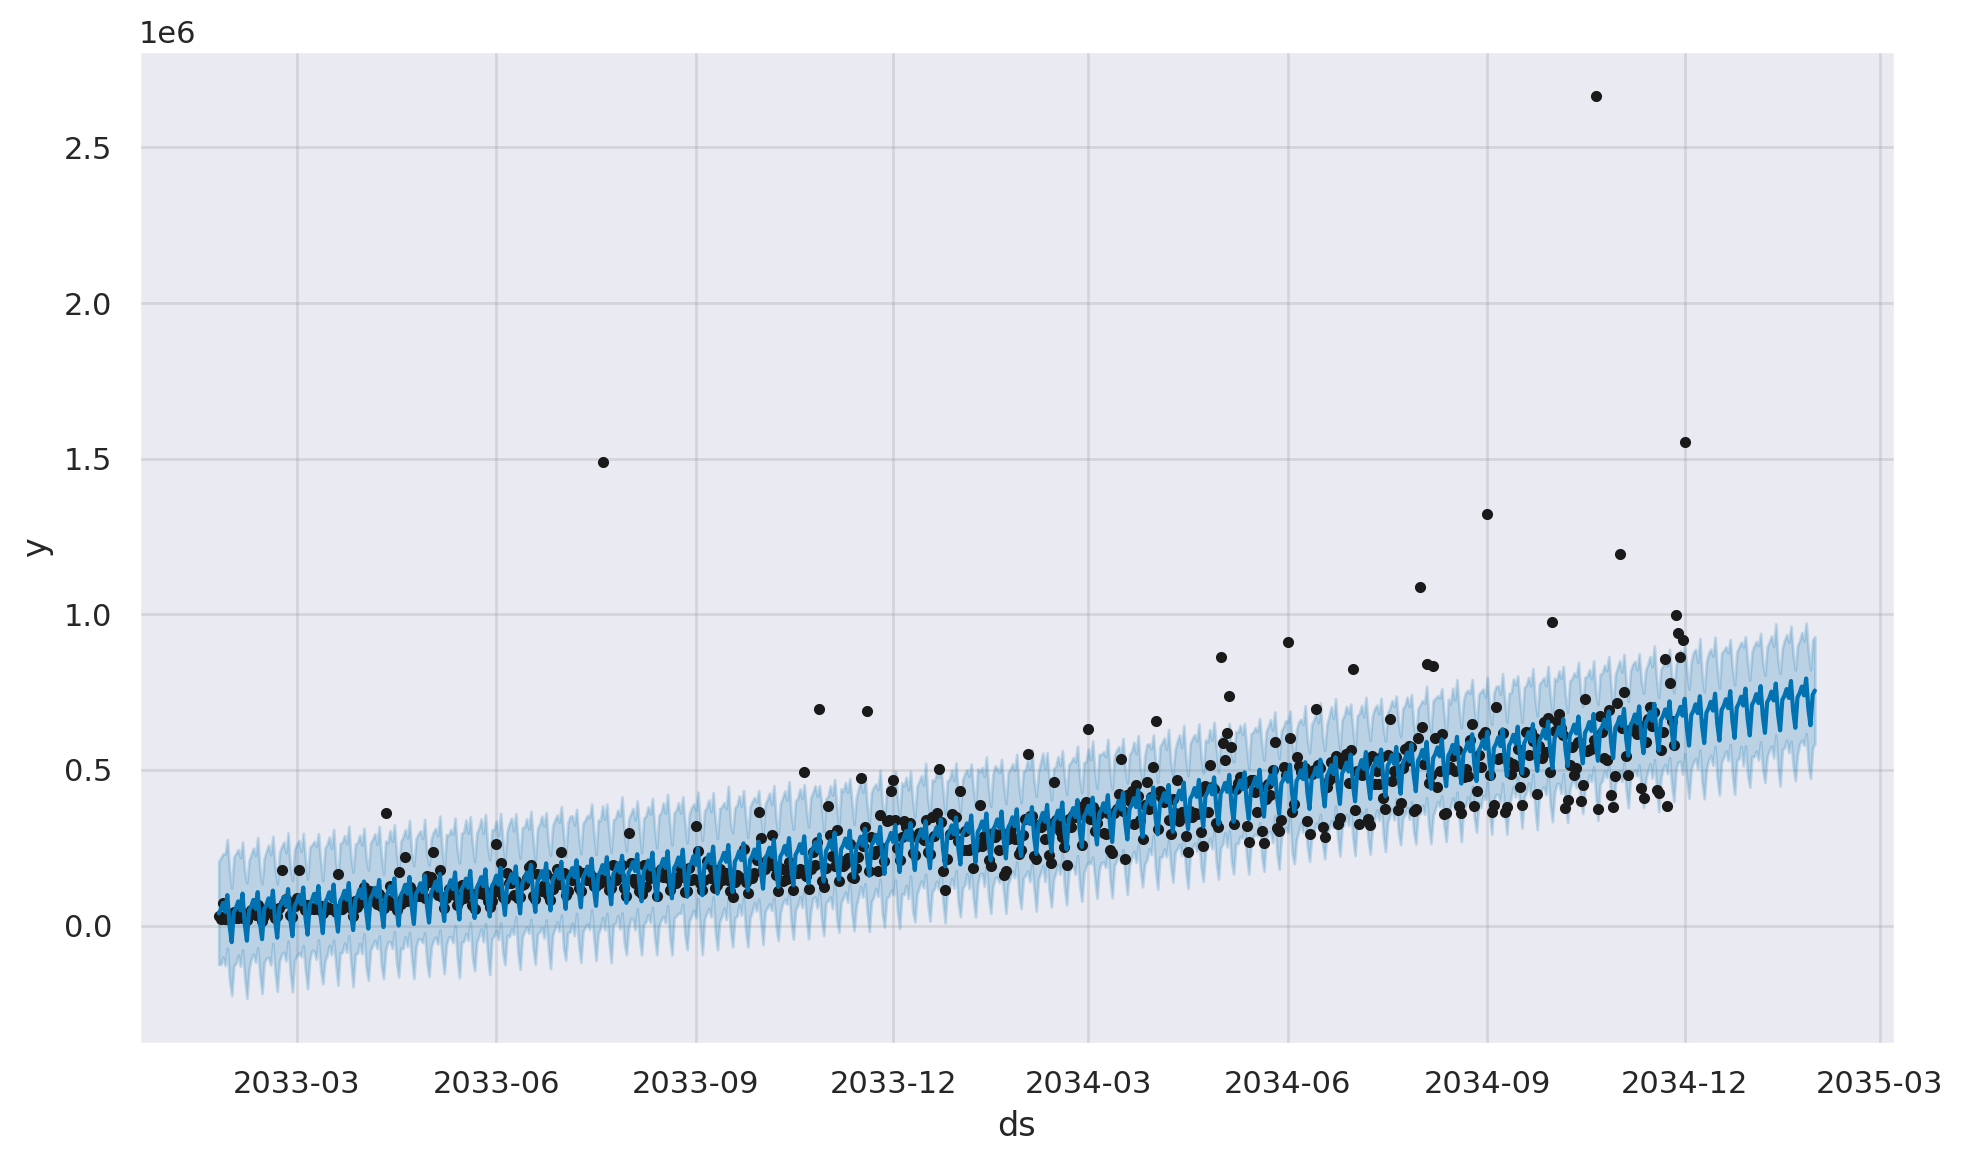

In [ ]:
# Use Prophet Plot
m.plot(forecast);

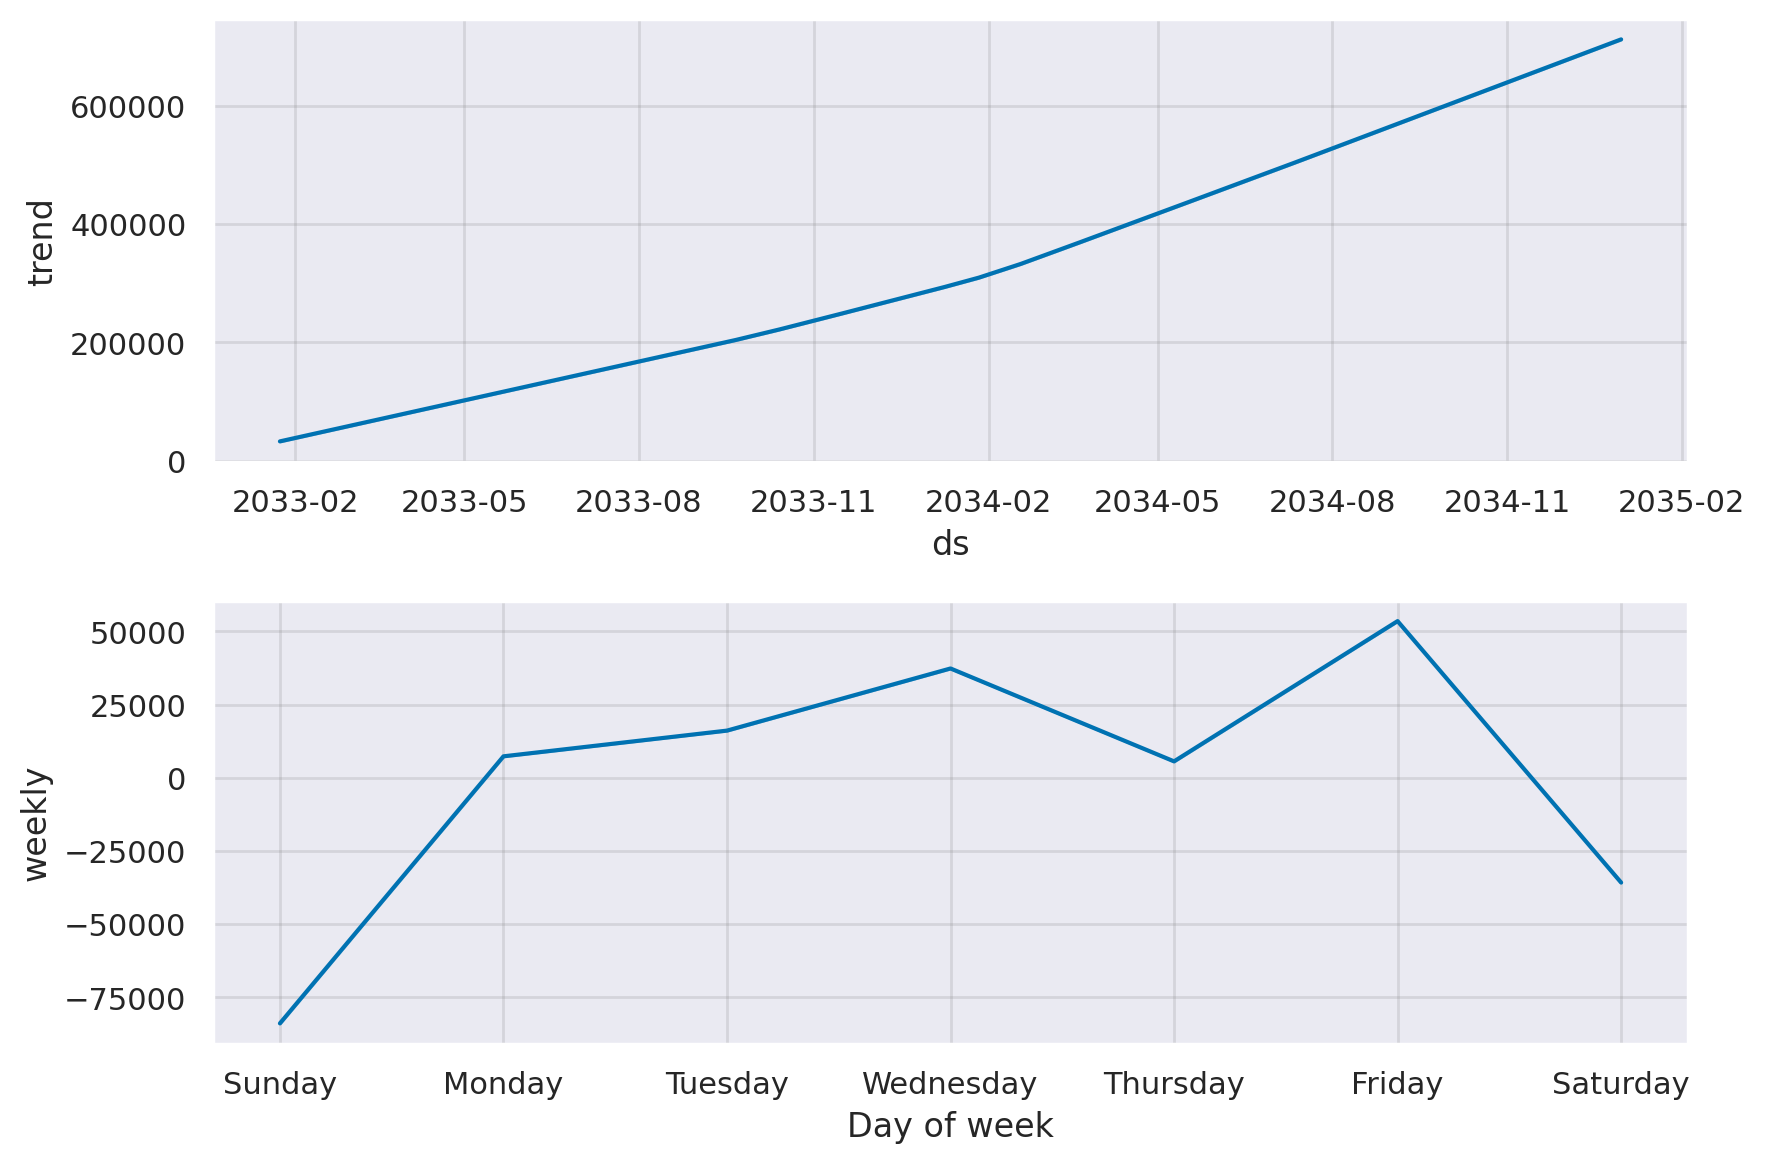

In [ ]:
# Let's see different componentss of the model separetely
m.plot_components(forecast);

In [ ]:
# From the trend graph, Prophet did a good job fitting the accelerated groth as well as the weekly seasonality as there are
# negative (or less than 0 ) activity on Saturday and Sunday

In [ ]:
print(",".join(forecast.columns))

ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat


In [ ]:
df.head()

ds         y
0 2033-01-24  30777.09
1 2033-01-25  21963.14
2 2033-01-26  72914.78
3 2033-01-27  20217.99
4 2033-01-28  36659.05

In [ ]:
def make_comparison_dataframe(historical, forecast):
  """Join the history with the forecast.forecast
    The resulting dataset will contain columns 'yhat', 'yaht_lowr', 'yhat_upper' and 'y'.
  """
  return forecast.set_index("ds")[["yhat","yhat_lower","yhat_upper"]].join(historical.set_index("ds"))

In [ ]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

yhat     yhat_lower     yhat_upper   y
ds                                                         
2035-01-28  643697.197308  472632.556273  821423.771035 NaN
2035-01-29  741631.065564  572566.085776  916981.694039 NaN
2035-01-30  755082.458725  583760.953426  927978.430302 NaN

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo2tgo9k_/zky1psyq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo2tgo9k_/wzus6wgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29850', 'data', 'file=/tmp/tmpo2tgo9k_/zky1psyq.json', 'init=/tmp/tmpo2tgo9k_/wzus6wgr.json', 'output', 'file=/tmp/tmpo2tgo9k_/prophet_model186ecf41/prophet_model-20240307234943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:49:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


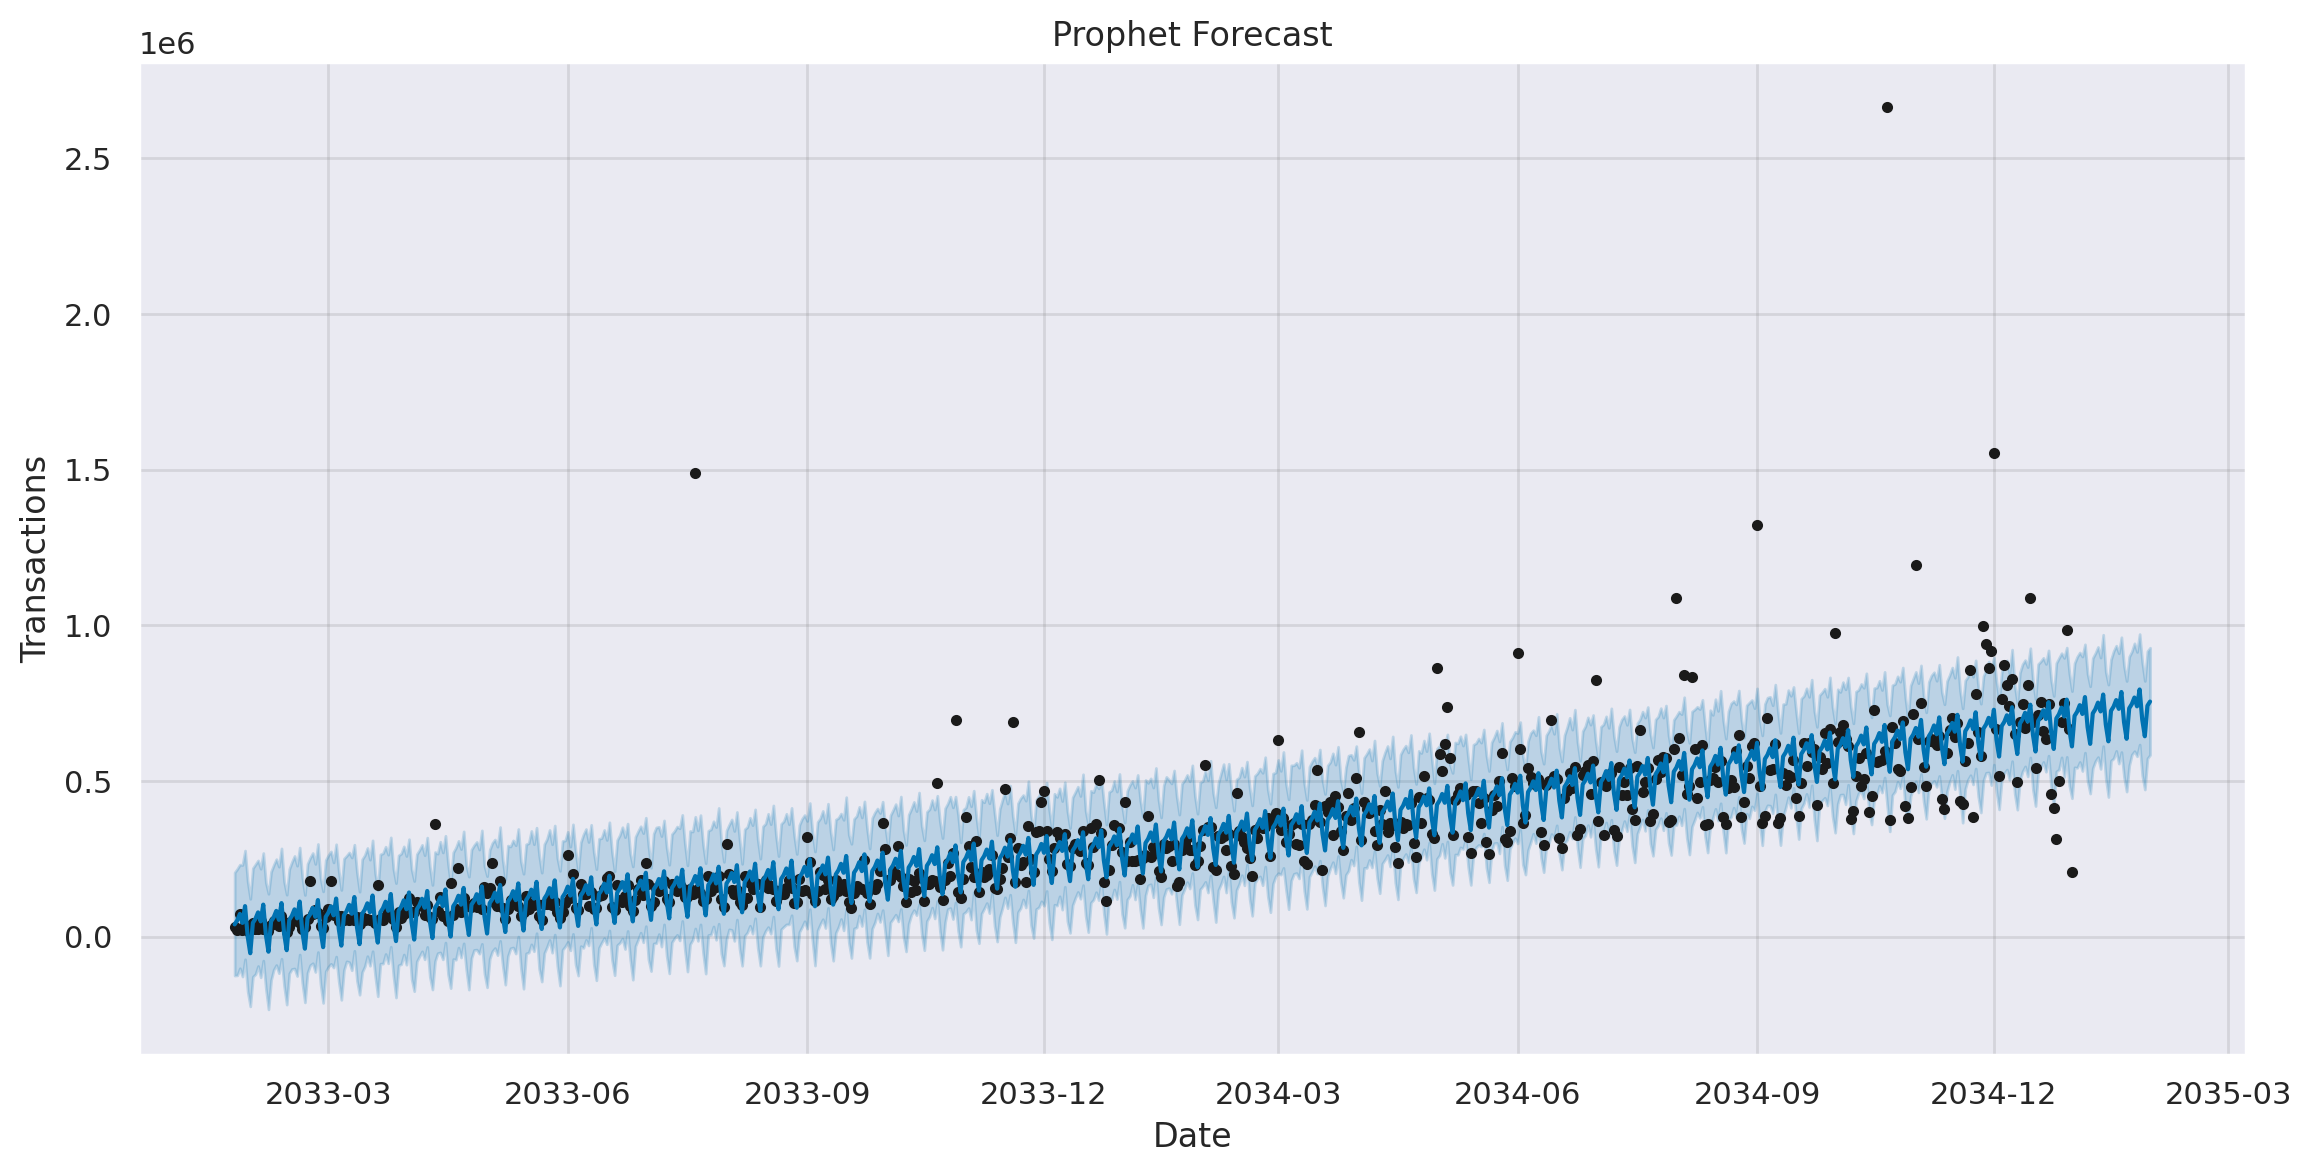

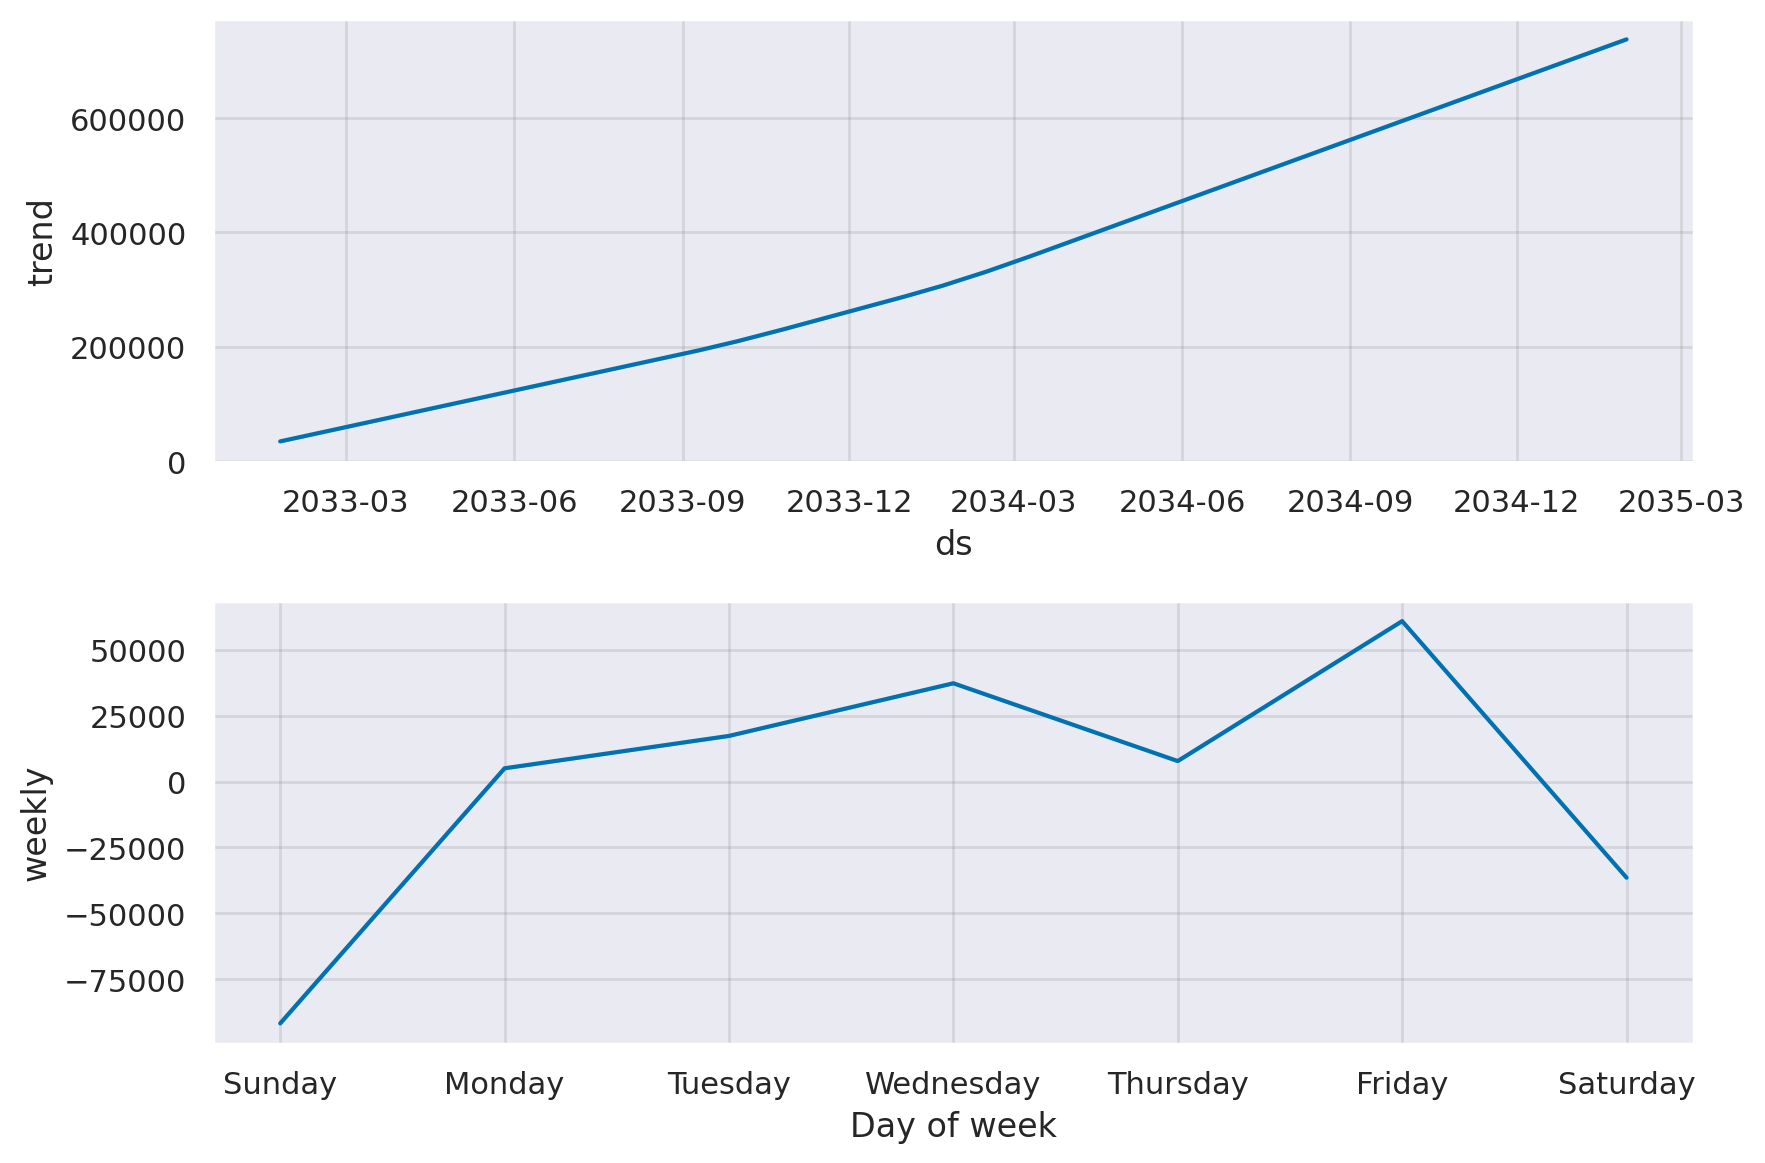

In [ ]:
# Here is an alternative way of performing above steps
import pandas as pd
!pip install prophet
from prophet import Prophet

# Prepare data in the format required by Prophet
df.columns = ["ds","y"]
df_prophet = df

# Alternative way
#df_prophet = pd.DataFrame({"ds": data.index, "y": data["amount_usd_in_cents"]})  # Assume "amount" is your transaction column
#df_prophet = series.reset_index()

# Create and fit the Prophet model
model = Prophet()  # Optionally specify seasonalities or changepoints
model.fit(df_prophet)

# Define the period for which we want a forecast
future_dates = pd.date_range(start=df_prophet.ds.max(), periods=30, freq="D")
forecast_df = model.make_future_dataframe(periods=len(future_dates))

# Generate the forecast
forecast = model.predict(forecast_df)

# Plot the results
fig = model.plot(forecast)
fig.set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Prophet Forecast")
plt.show()

# (Optional) Plot components of the forecast
fig2 = model.plot_components(forecast)

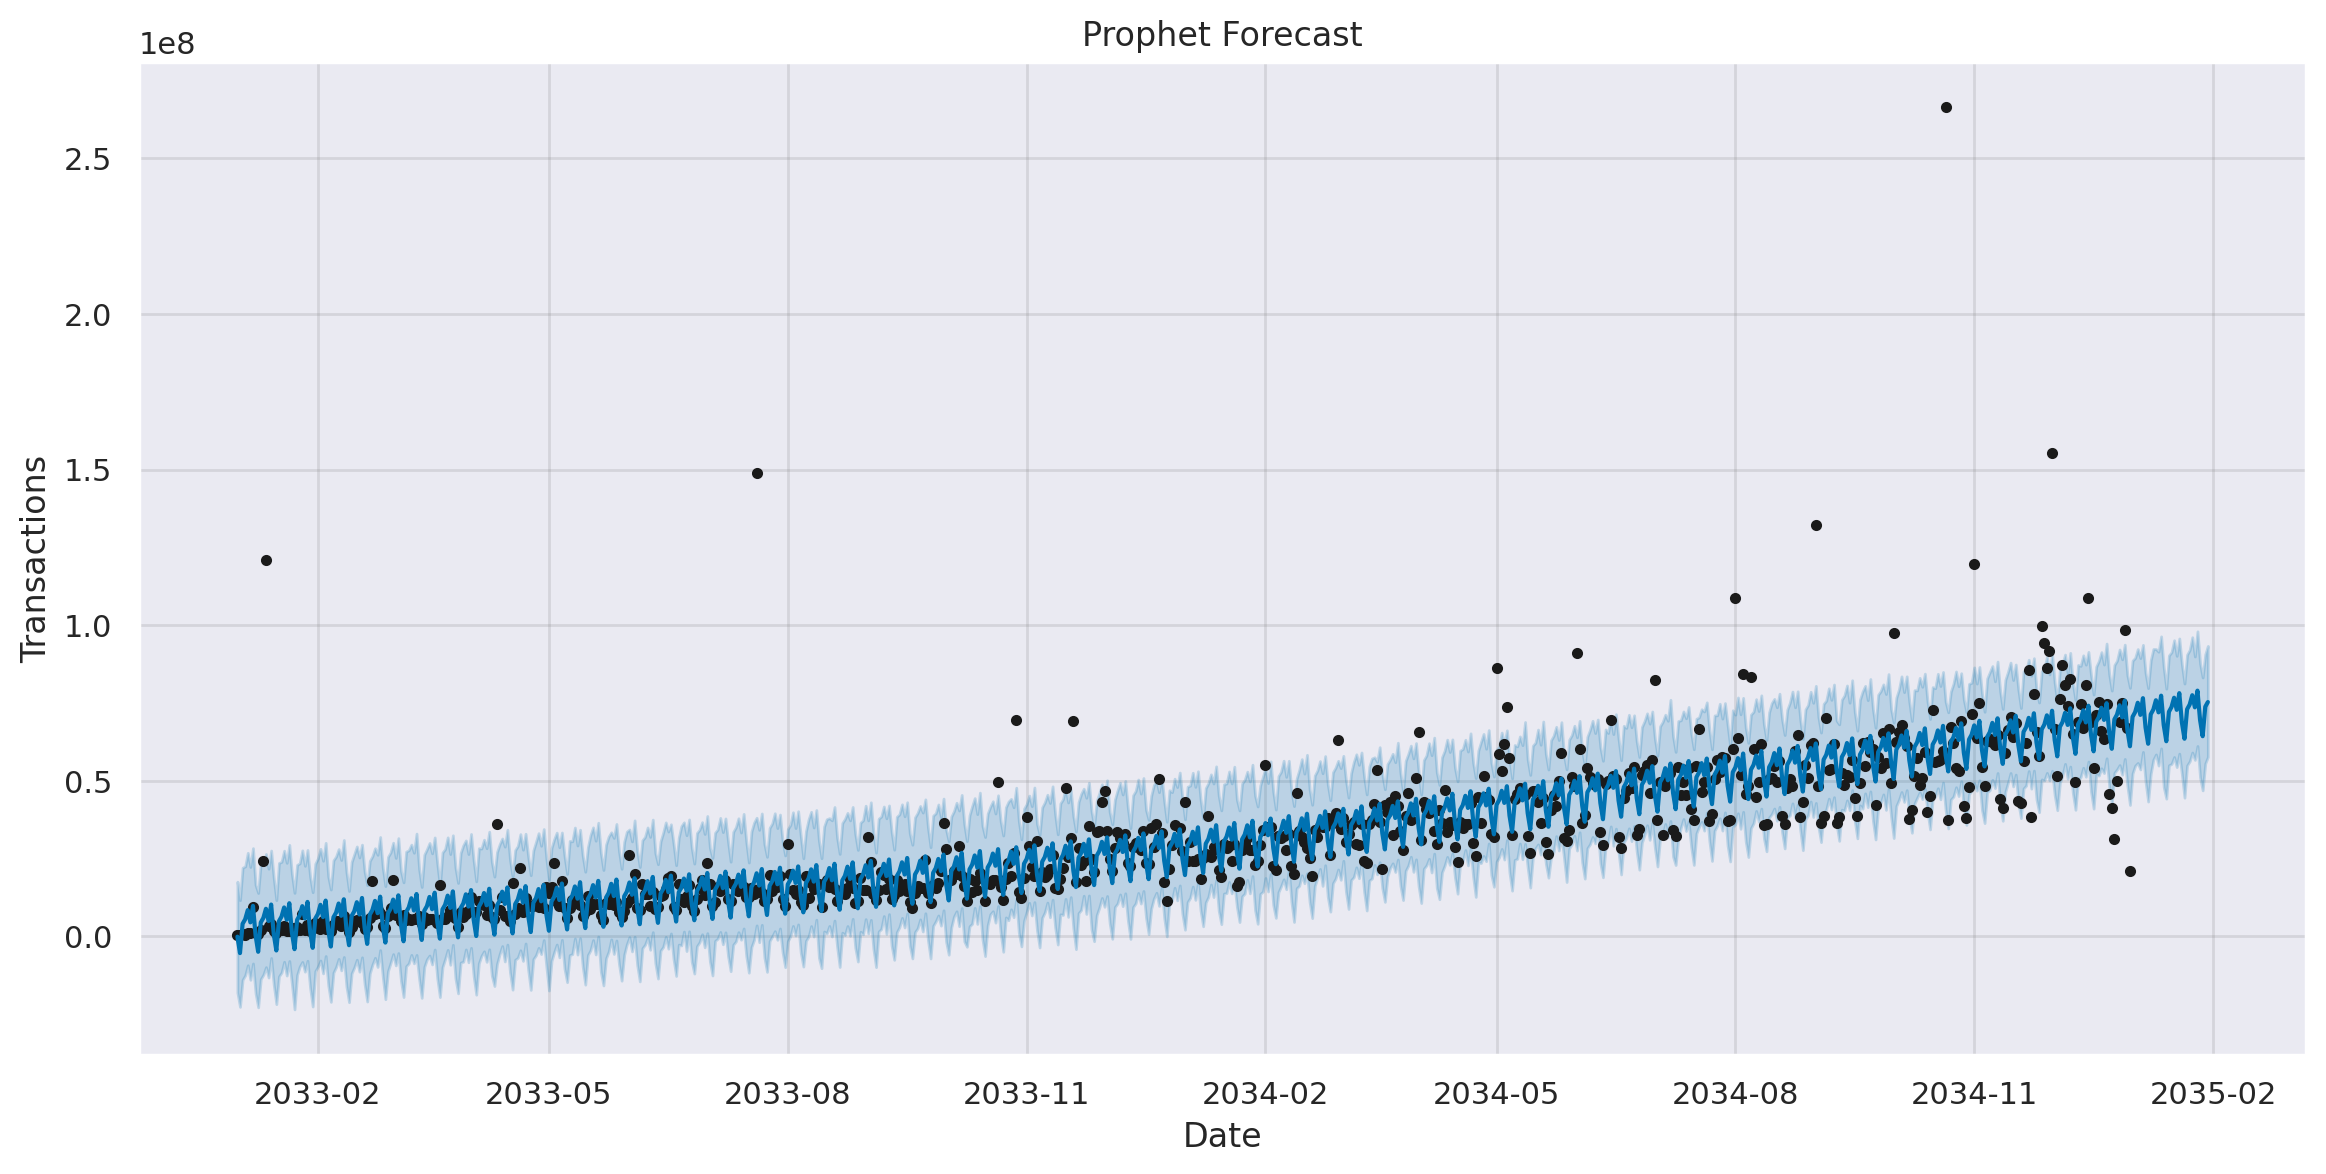

In [ ]:
fig = model.plot(forecast)
fig.set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Prophet Forecast")
plt.show()

In [ ]:
# Forcast Metrics Computations

In [ ]:
forecast.head()

ds         trend     yhat_lower     yhat_upper   trend_lower  \
0 2033-01-24  34377.730317 -125011.020211  206131.992675  34377.730317   
1 2033-01-25  35072.988745 -124189.141079  217740.283306  35072.988745   
2 2033-01-26  35768.247174 -101493.198700  231296.626077  35768.247174   
3 2033-01-27  36463.505603 -128026.088327  230305.253834  36463.505603   
4 2033-01-28  37158.764031  -72693.084155  276520.354578  37158.764031   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  34377.730317     5019.457375           5019.457375           5019.457375   
1  35072.988745    17306.440216          17306.440216          17306.440216   
2  35768.247174    37272.984723          37272.984723          37272.984723   
3  36463.505603     7765.300364           7765.300364           7765.300364   
4  37158.764031    60853.651874          60853.651874          60853.651874   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0   5019.457375   5019.457375   5019.457375                   0.0   
1  17306.440216  17306.440216  17306.440216                   0.0   
2  37272.984723  37272.984723  37272.984723                   0.0   
3   7765.300364   7765.300364   7765.300364                   0.0   
4  60853.651874  60853.651874  60853.651874                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  39397.187692  
1                         0.0                         0.0  52379.428961  
2                         0.0                         0.0  73041.231897  
3                         0.0                         0.0  44228.805967  
4                         0.0                         0.0  98012.415905

In [ ]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.

       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [ ]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head(n=5)

yhat     yhat_lower     yhat_upper         y
ds                                                              
2033-01-24  39397.187692 -125011.020211  206131.992675  30777.09
2033-01-25  52379.428961 -124189.141079  217740.283306  21963.14
2033-01-26  73041.231897 -101493.198700  231296.626077  72914.78
2033-01-27  44228.805967 -128026.088327  230305.253834  20217.99
2033-01-28  98012.415905  -72693.084155  276520.354578  36659.05

In [ ]:
cmp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737 entries, 2033-01-24 to 2035-01-30
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yhat        737 non-null    float64
 1   yhat_lower  737 non-null    float64
 2   yhat_upper  737 non-null    float64
 3   y           707 non-null    float64
dtypes: float64(4)
memory usage: 45.0 KB


In [ ]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.

       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [ ]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE nan
MAE nan


In [ ]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))

    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Posts"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)


show_forecast(cmp_df, prediction_size, 100, "New posts on Medium")